In [1]:
import numpy as np
import pandas as pd

import sklearn.model_selection 
import sklearn.ensemble

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bayesian_optimiser as bayopt

In [3]:
########################################################################
############################# TEST #####################################
########################################################################
####### using the uci breast cancer data set with random forests #######
# https://www.datascience.com/resources/notebooks/random-forest-intro

In [4]:
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

In [5]:
data = pd.read_csv("../hyperparam_searcher/data/wdbc.data", names=names)

In [6]:
# clean up
# Setting 'id_number' as our index
data = data.drop(columns=['id_number'])

# Converted to binary to help later on with models and plots
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

labels = data.iloc[:, data.columns == 'diagnosis'].copy()
data   = data.iloc[:, data.columns != 'diagnosis']

In [7]:
data.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean           ...             radius_worst  \
0                 0.07871           ...                    25.38   
1                 0.05667           ...                    24.99   
2                 0.05999           ...                    23.57   
3                 0.09744           ...                    14.91   
4                 0.05883           ...                    22.54   

   texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0          17.33           184.60      2019.0            0.1622   
1          23.41           158.80      1956.0            0.1238   
2          25.53           152.50      1709.0            0.1444   
3          26.50            98.87       567.7            0.2098   
4          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave_points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678  

[5 rows x 30 columns]

In [8]:
labels.head()

diagnosis
0          1
1          1
2          1
3          1
4          1

In [9]:
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(data,
                                                                                             labels,
                                                                                             test_size = 0.20)

In [16]:
def convert_list(dataset, value):
    idx = int(len(dataset) * value)
    if idx == len(dataset):
        idx = len(dataset) - 1
   
    return dataset[idx]

def param_translator(job):
    # all hyperparams are assumed to be in range of [0,1] - translate to real values
    max_features = ['auto', 'sqrt', 'log2', None]
    criterion    = ['gini', 'entropy']
    
    hyper = job["sample"]
    config = {}

    config['max_depth']    = int(3 * hyper[0]) + 2
    config['max_features'] = convert_list(max_features, hyper[1])

    if (hyper.shape[0] > 2):
        config['bootstrap']    = hyper[2] > 0.5
    else:
        config['bootstrap']    = True
        
    if (hyper.shape[0] > 3):
        config['criterion']    = convert_list(criterion, hyper[3])
    else:
        config['criterion']    = criterion[0]

    #config['random_state'] = 42
    
    return config                      

In [11]:
# Set the random state for reproductibility
def sample(params):    
    method = params["method"]
    model_params = param_translator(params)
    
    rf_model = sklearn.ensemble.RandomForestClassifier(**model_params)
    
    rf_model.fit(train_data, train_labels)

    predict = rf_model.predict(test_data)
    
    # maybe save the sample point??
    result = sklearn.metrics.accuracy_score(test_labels, predict)
    
    print method, ":", model_params, result

    # returning loss.. which approaches zero
    return 1.0 - result

In [12]:
def graph(model, next_sample, sampled_params, sampled_loss):
    fig = bayopt.graphing_callback_keypoint(model, next_sample, sampled_params, sampled_loss)
    plt.show()
    del fig

In [13]:
opt = bayopt.BayesianOptimizer(n_params=2,
                               initial_samples=3,
                               callback=graph)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.95614035087719296)
('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)
('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.93859649122807021)


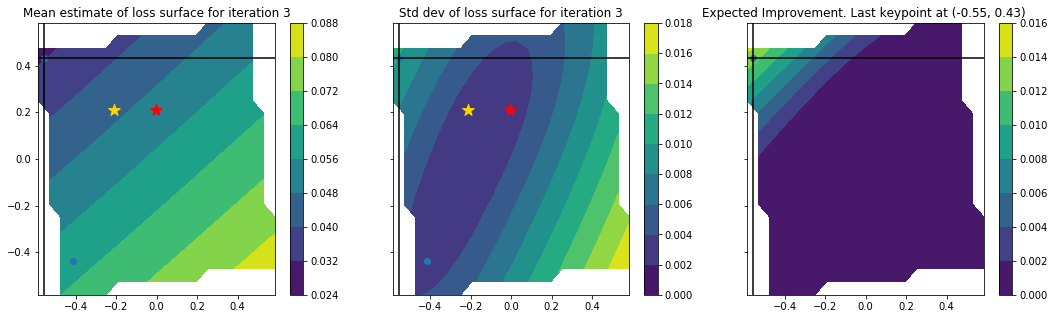

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


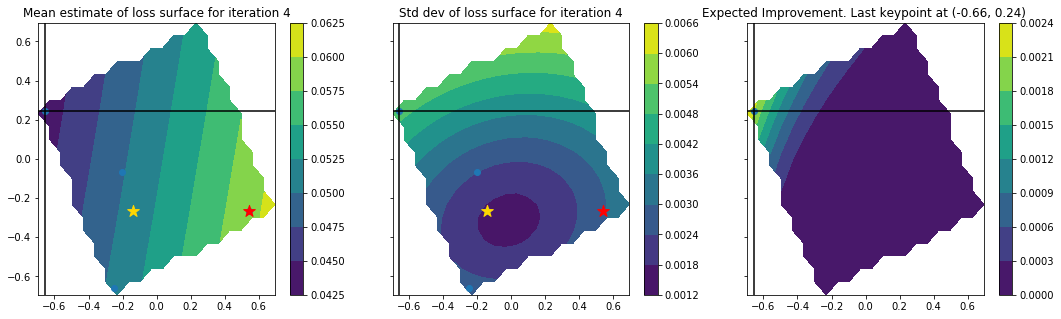

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.93859649122807021)


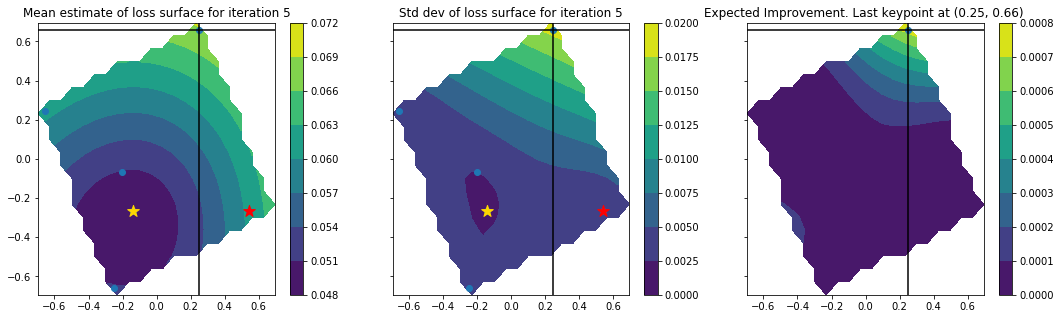

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


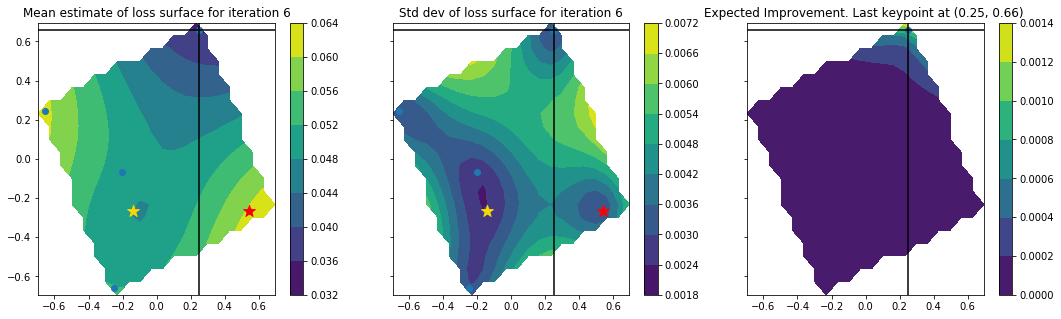

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


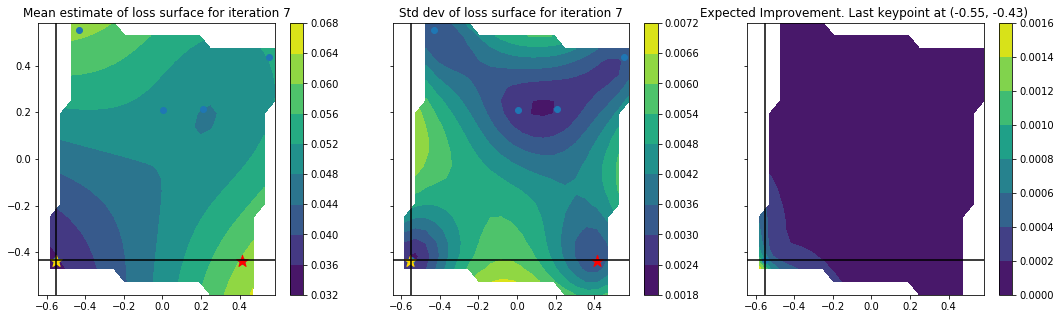

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


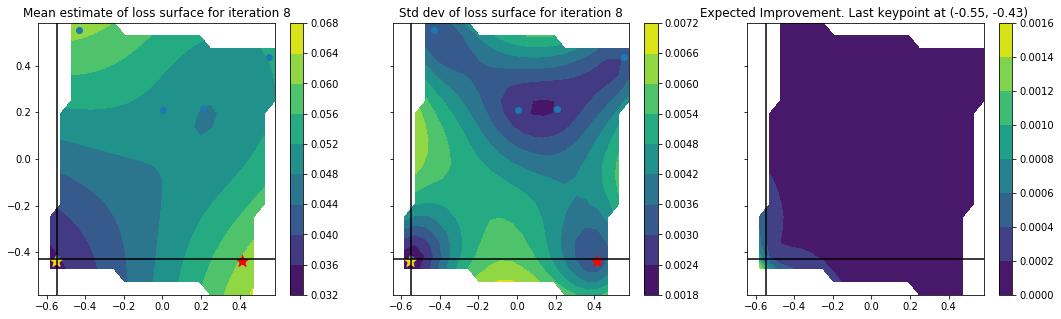

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.94736842105263153)


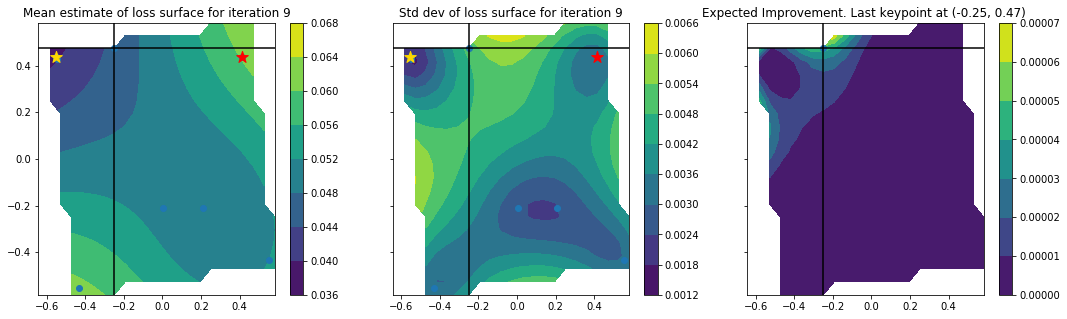

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.97368421052631582)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  6.31235516e-05]), 'nit': 3, 'funcalls': 48}
  " state: %s" % convergence_dict)


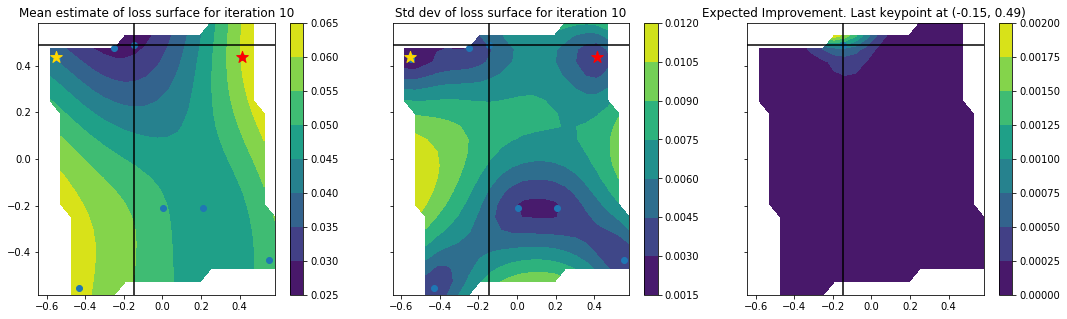

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


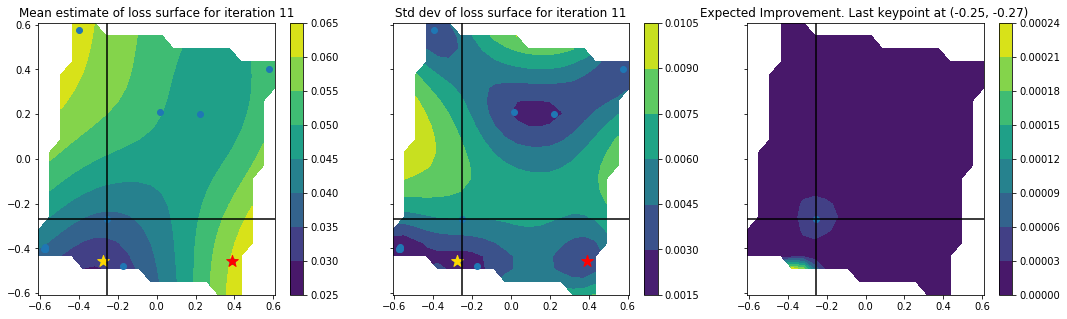

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


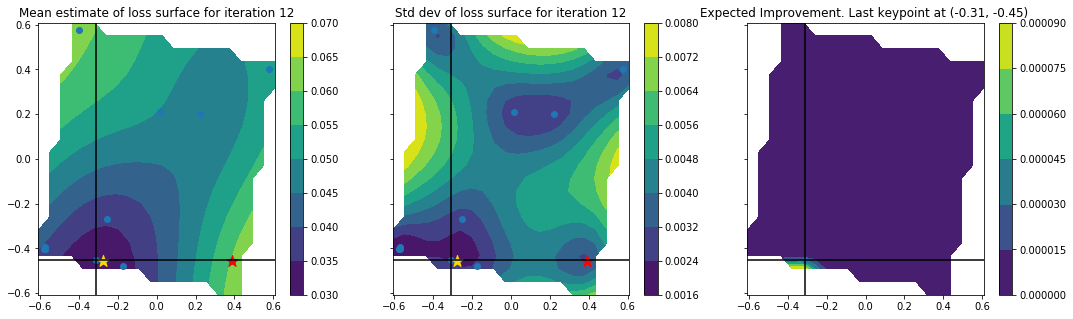

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


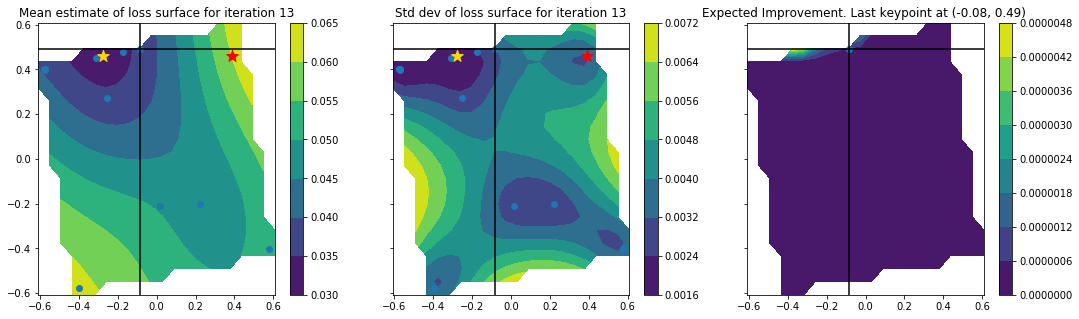

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


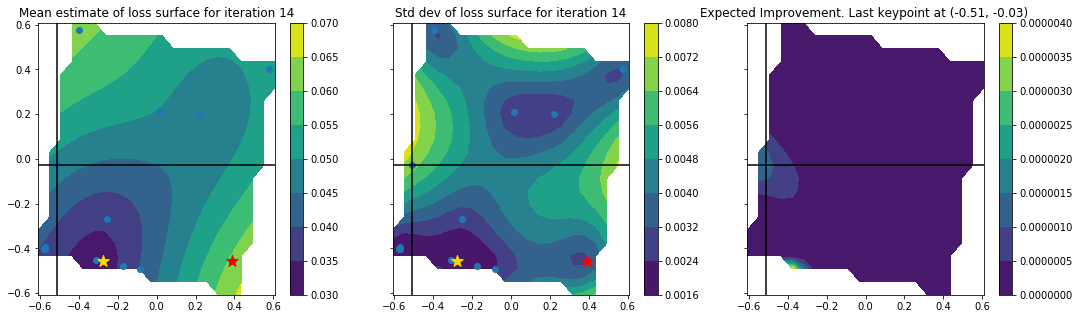

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.93859649122807021)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.25003644e-05]), 'nit': 5, 'funcalls': 50}
  " state: %s" % convergence_dict)


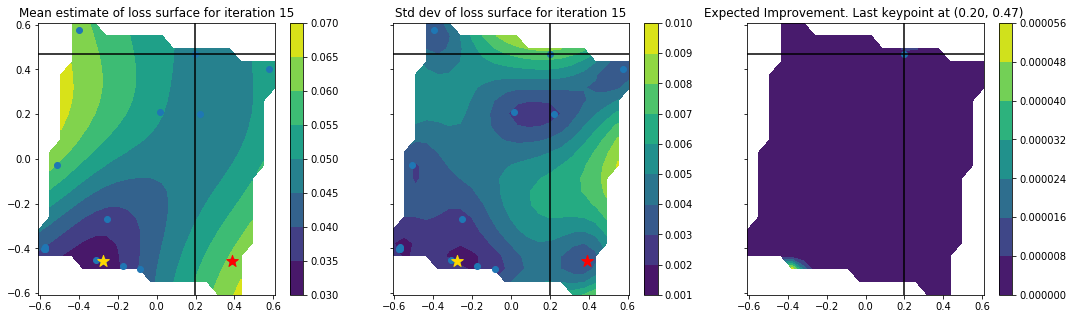

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.92982456140350878)


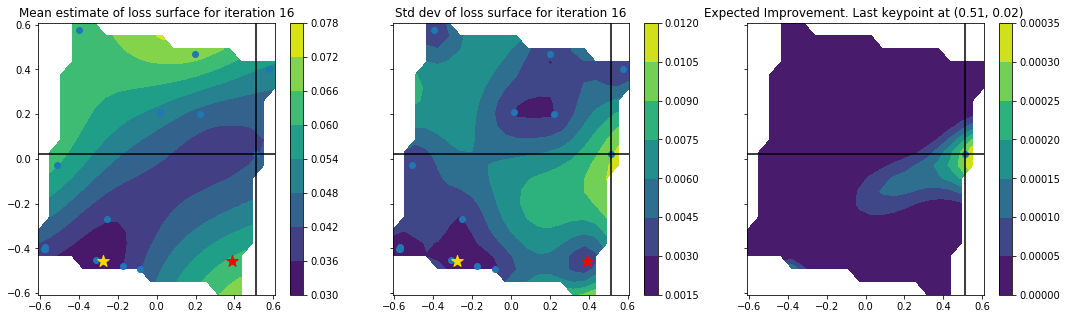

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.94736842105263153)


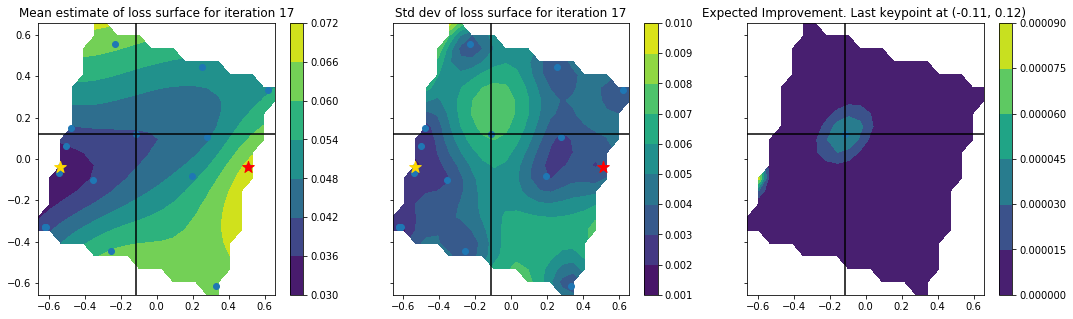

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.95614035087719296)


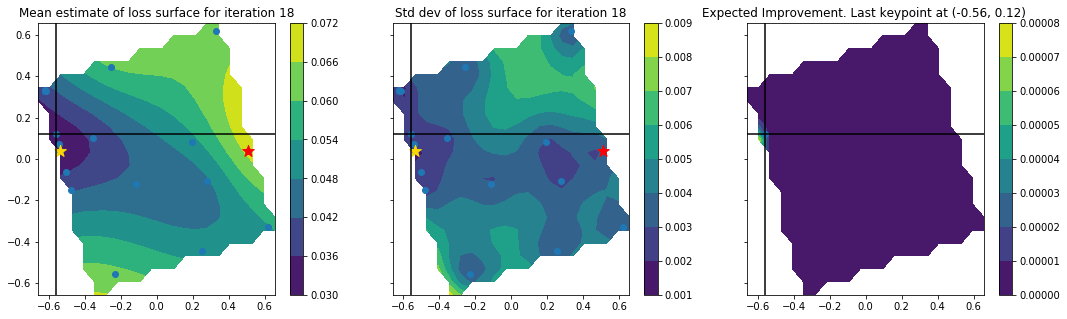

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.92982456140350878)


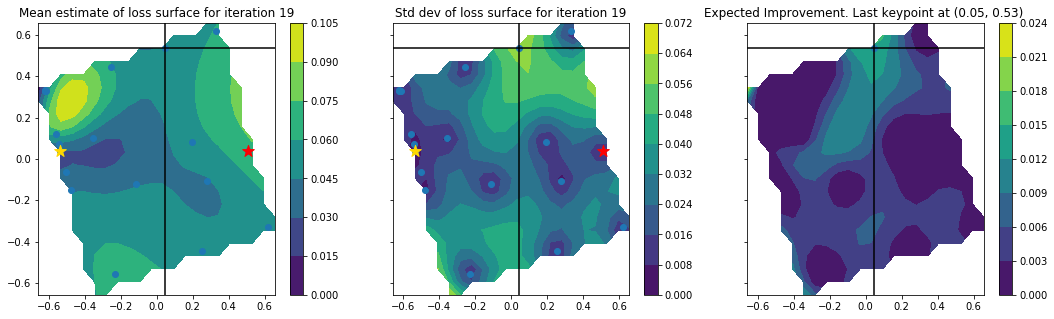

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.95614035087719296)


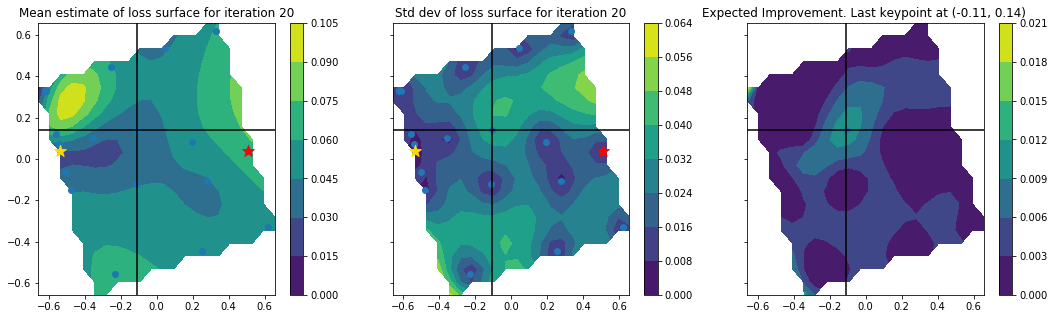

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.94736842105263153)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.55940515e-05]), 'nit': 6, 'funcalls': 52}
  " state: %s" % convergence_dict)


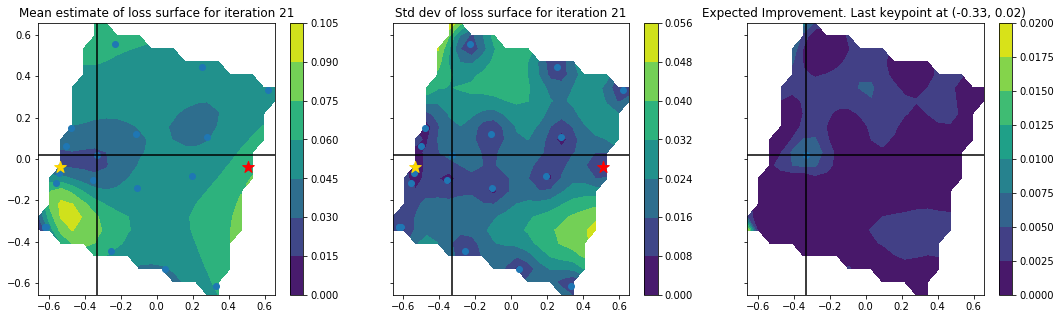

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.94736842105263153)


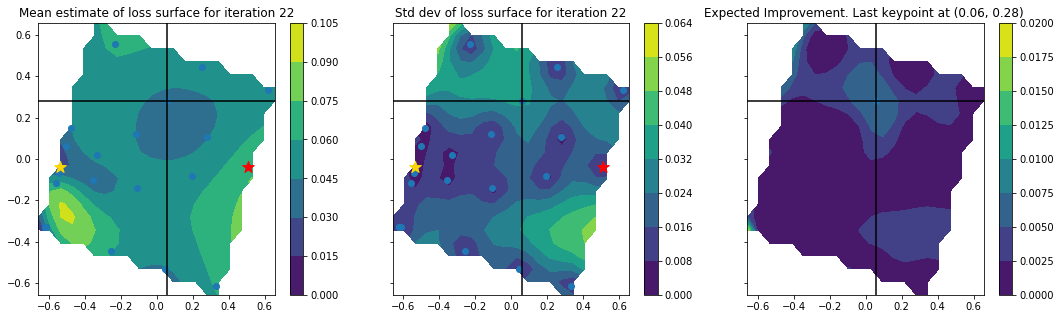

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.93859649122807021)


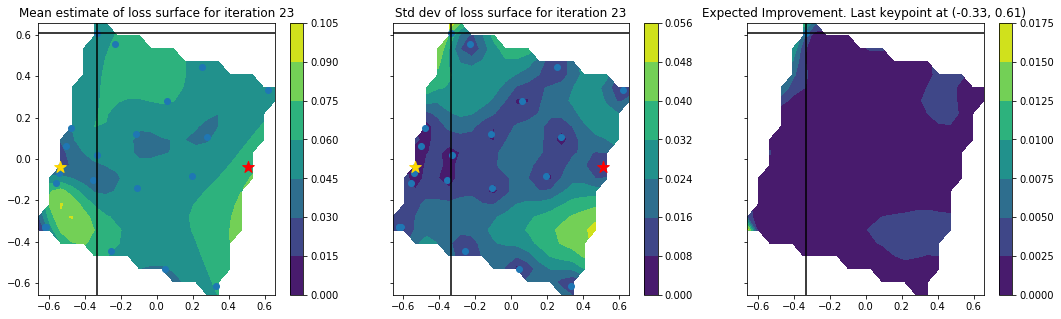

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.97368421052631582)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.21457034e-05]), 'nit': 4, 'funcalls': 49}
  " state: %s" % convergence_dict)


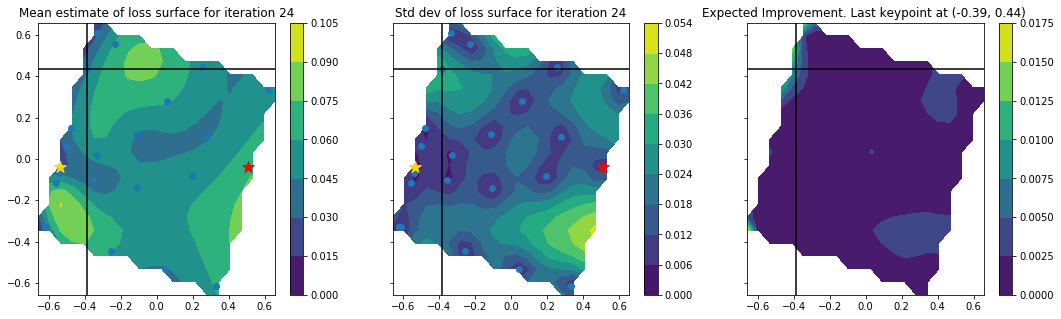

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


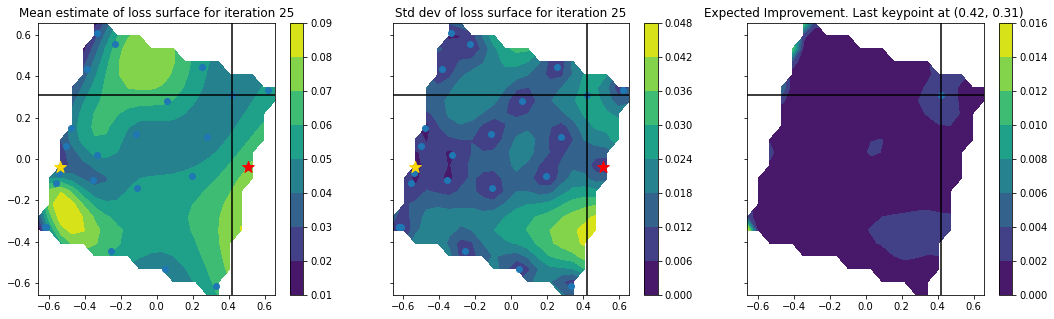

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.15722702e-05]), 'nit': 4, 'funcalls': 53}
  " state: %s" % convergence_dict)


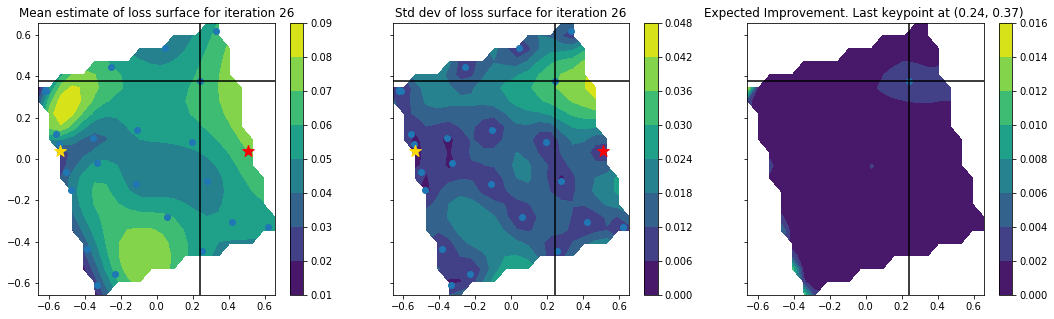

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


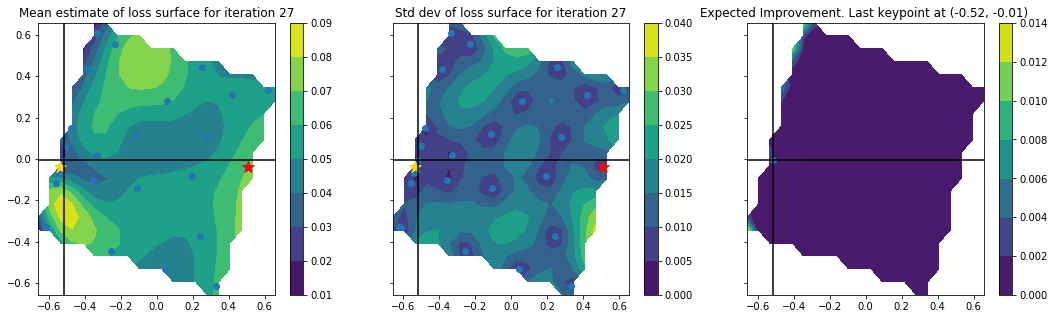

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.96491228070175439)


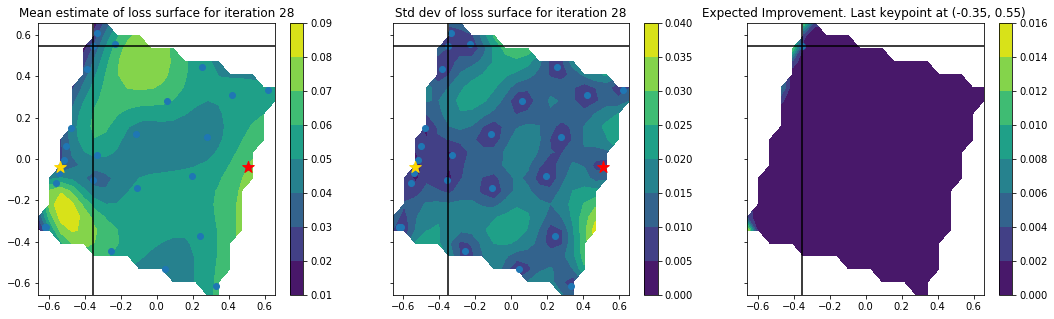

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


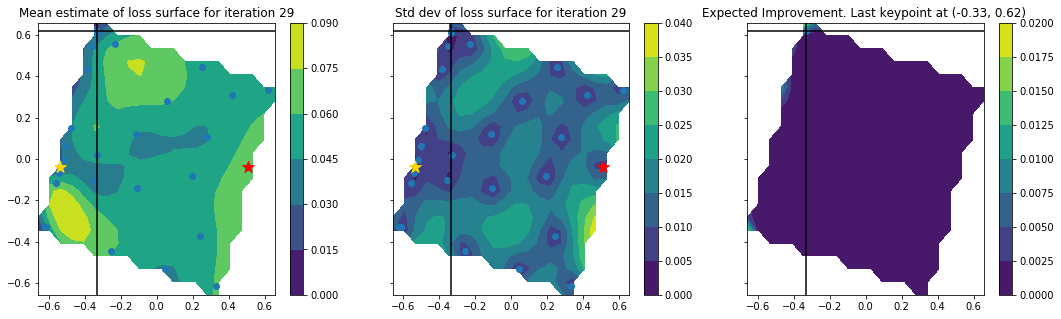

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


In [14]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=30)

In [15]:
idx = np.argmin(yp) 
print "best:", yp[idx,0], "acc:", (1.0 - yp[idx,0]), " is at:", xp[idx]
print "    ", param_translator({"sample": xp[idx]})

best: 0.0263157894737 acc: 0.973684210526  is at: [ 0.99941257  0.69432756]
     {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}


In [18]:
opt = bayopt.BayesianOptimizer(n_params=4,
                               initial_samples=3,
                               callback=graph)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2}, 0.93859649122807021)
('sample point:', {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4}, 0.97368421052631582)
('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.92982456140350878)


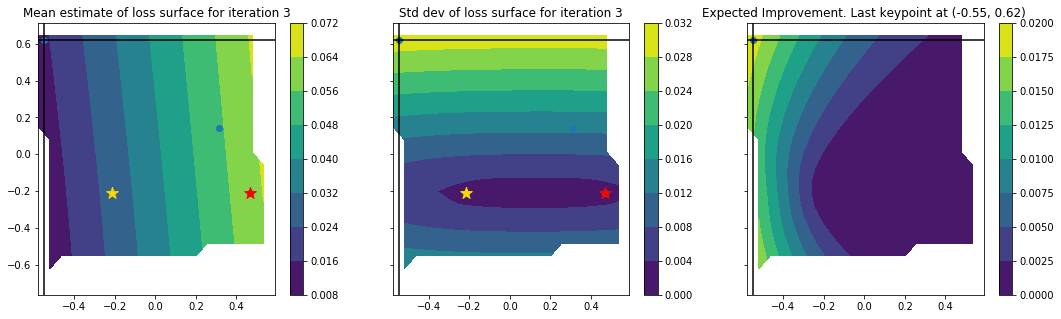

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.96491228070175439)


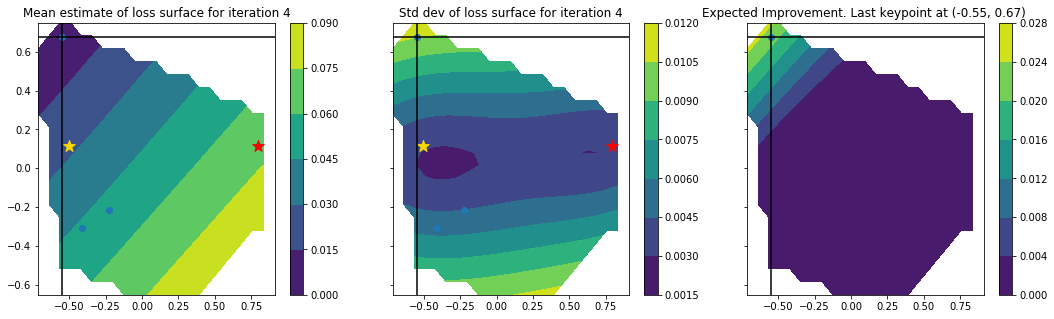

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4}, 0.94736842105263153)


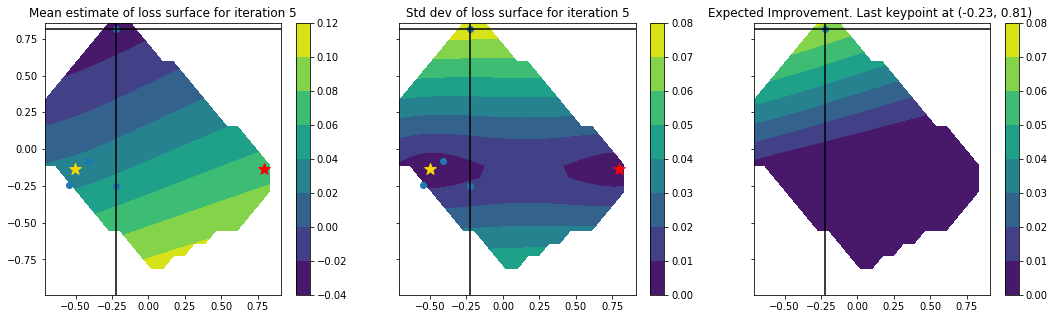

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4}, 0.95614035087719296)


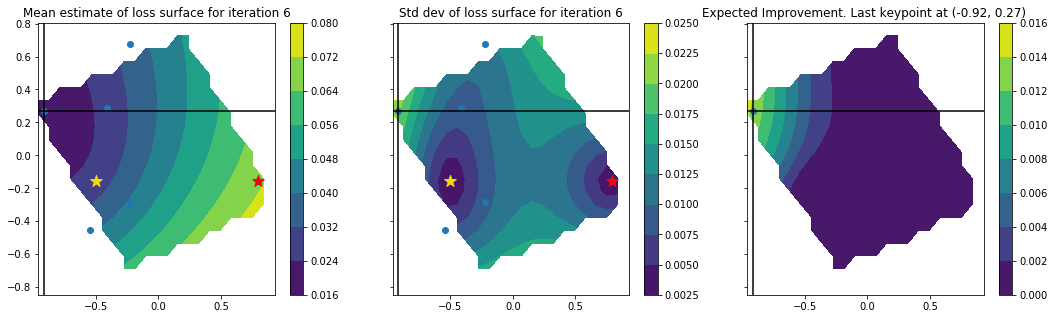

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.96491228070175439)


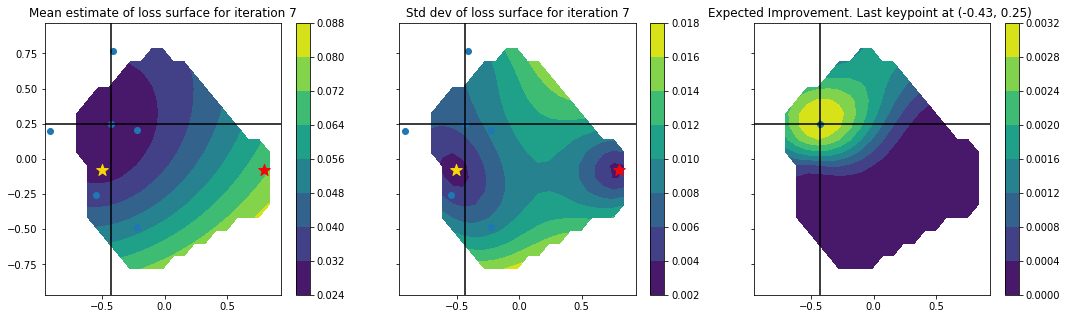

('sample point:', {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.97368421052631582)


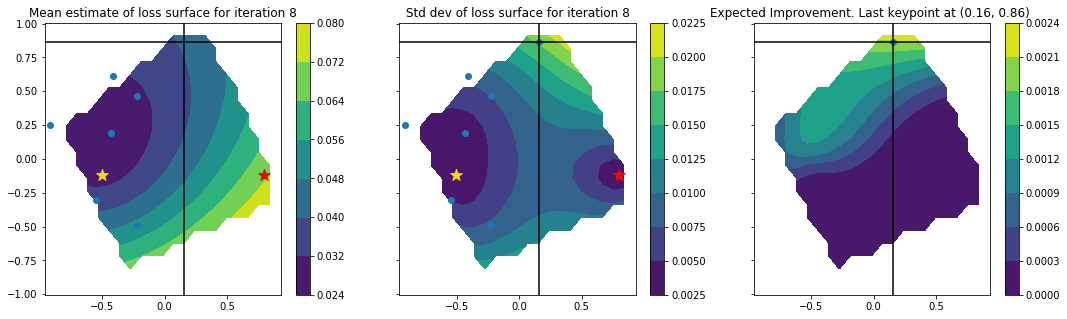

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4}, 0.95614035087719296)


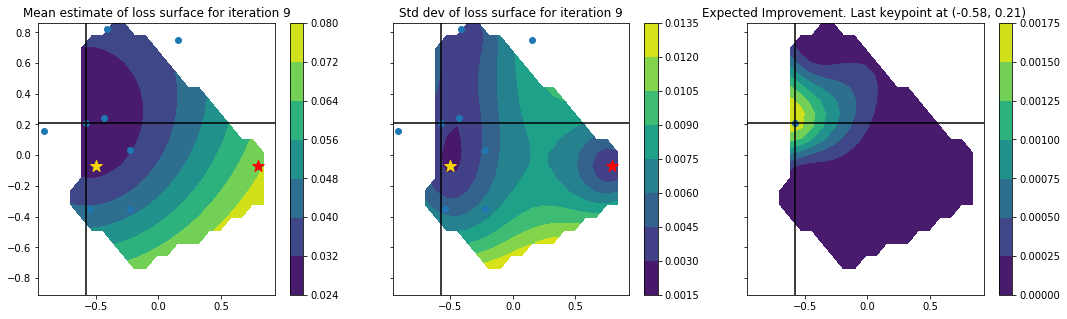

('sample point:', {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.94736842105263153)


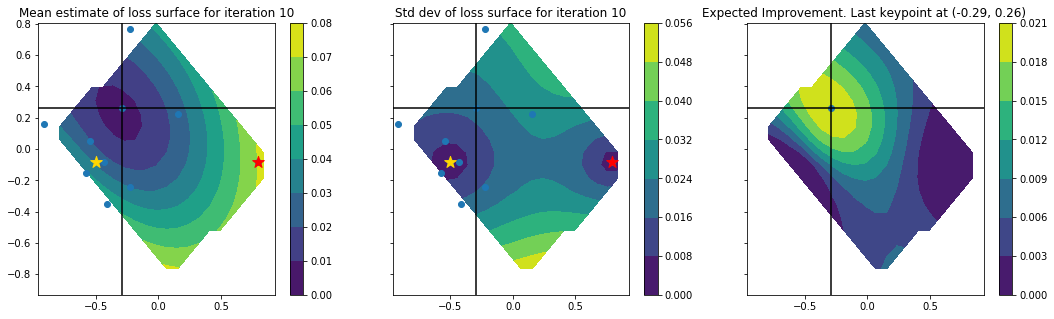

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


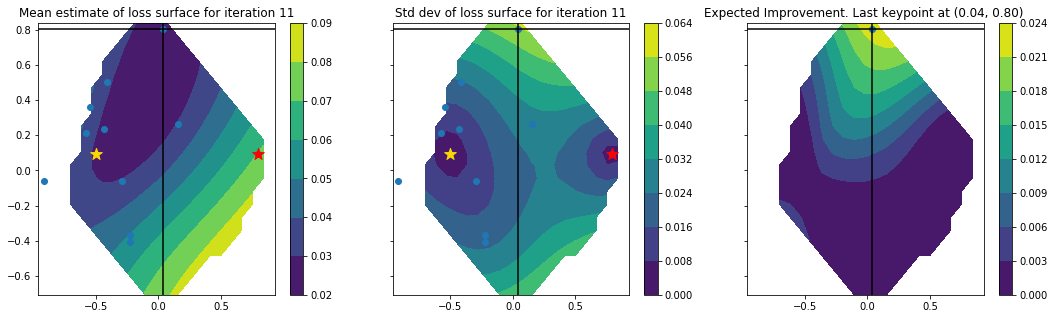

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


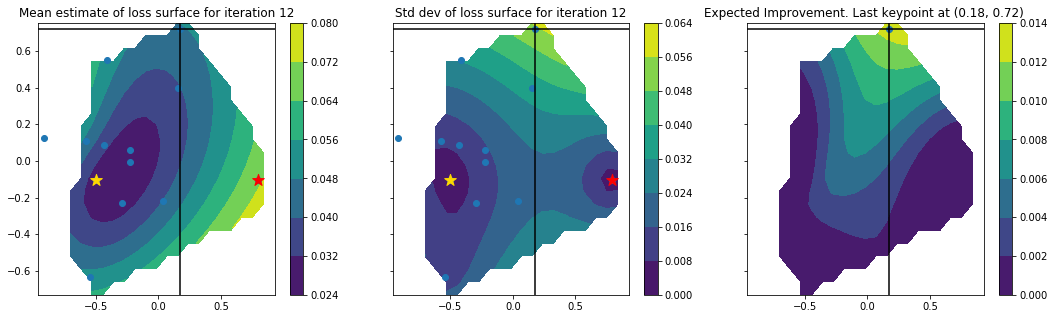

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2}, 0.92105263157894735)


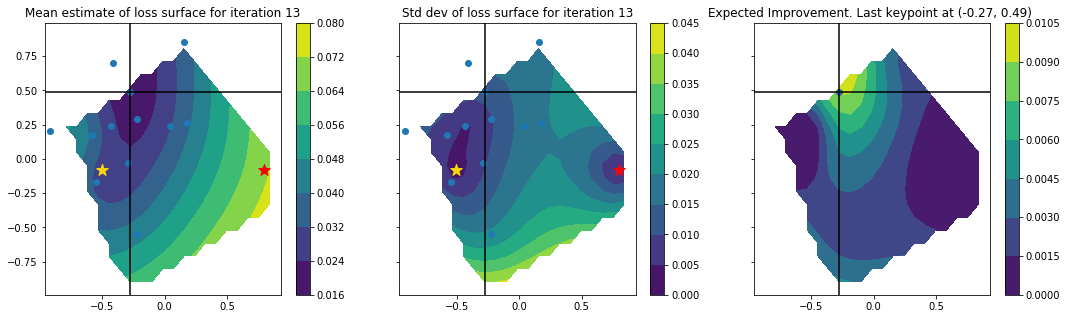

('sample point:', {'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.99122807017543857)


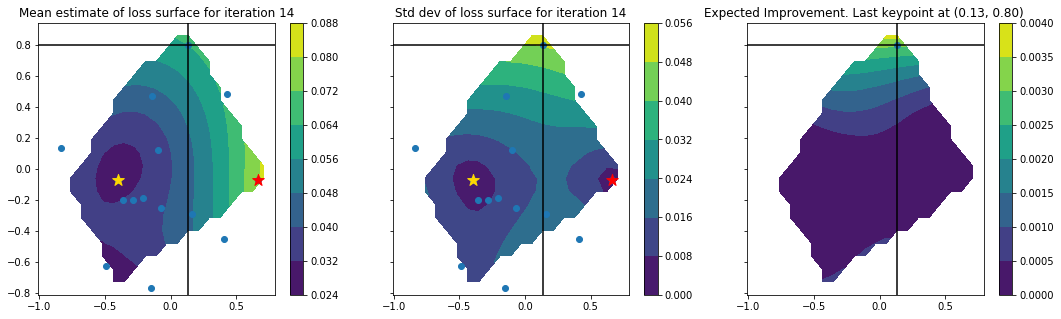

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2}, 0.92982456140350878)


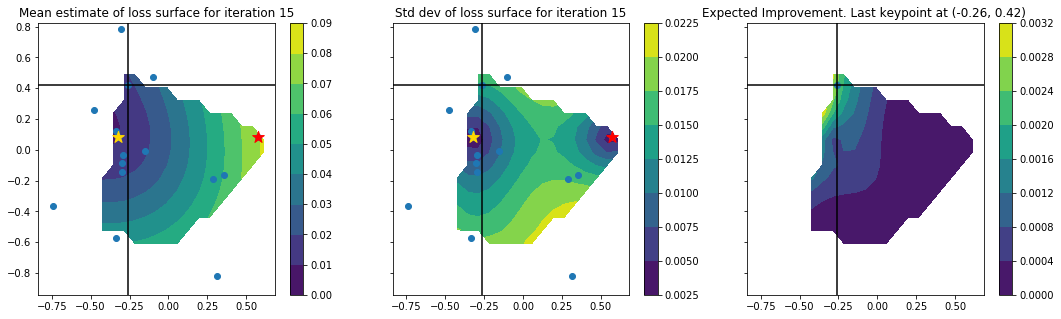

('sample point:', {'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4}, 0.96491228070175439)


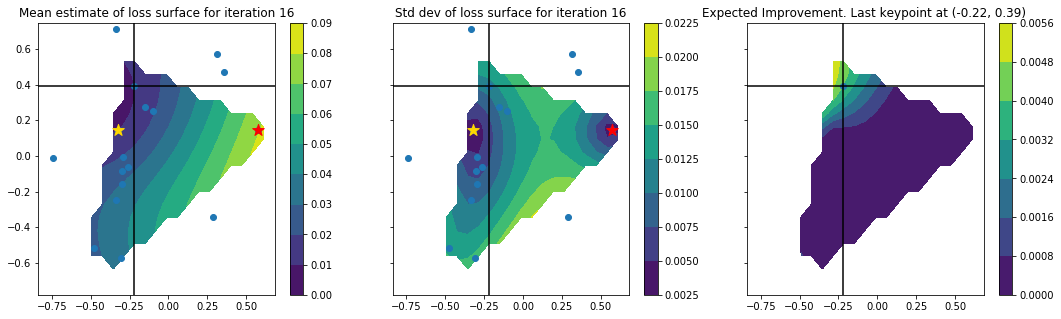

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.98245614035087714)


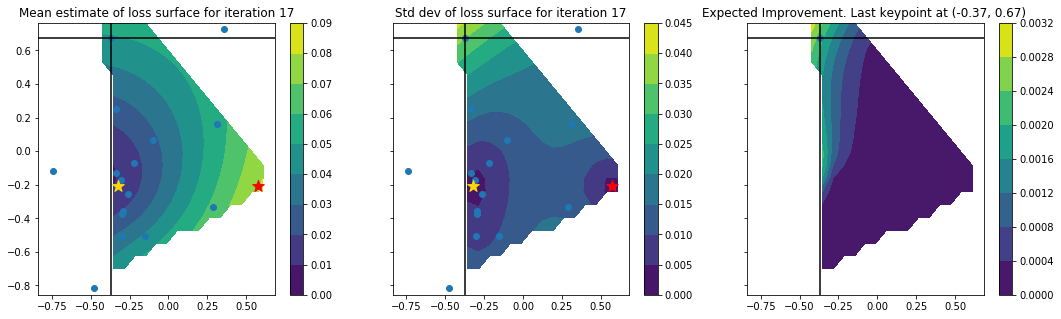

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.97368421052631582)


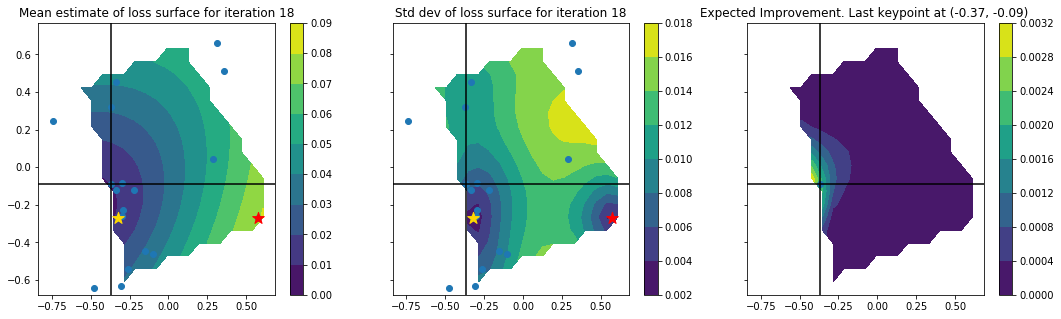

('sample point:', {'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.96491228070175439)


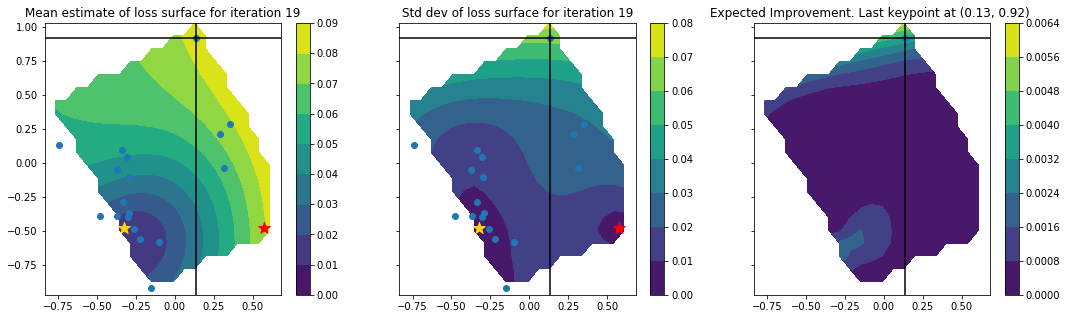

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.92982456140350878)


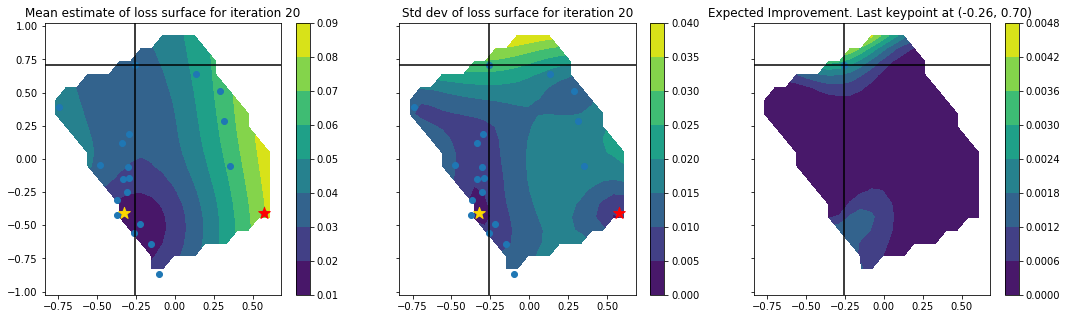

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 3}, 0.97368421052631582)


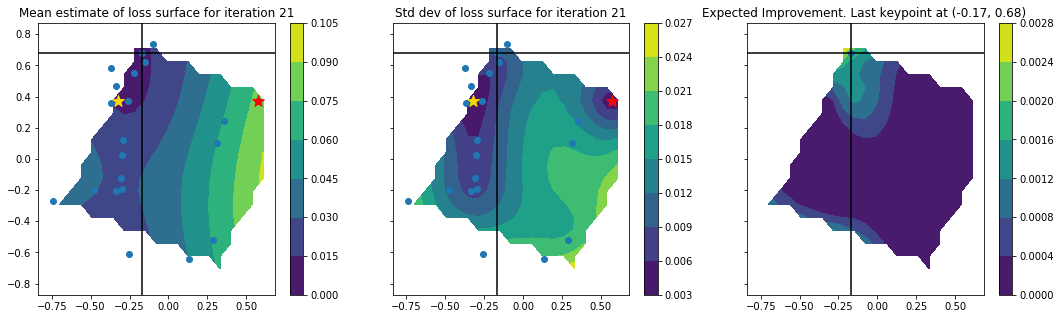

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.98245614035087714)


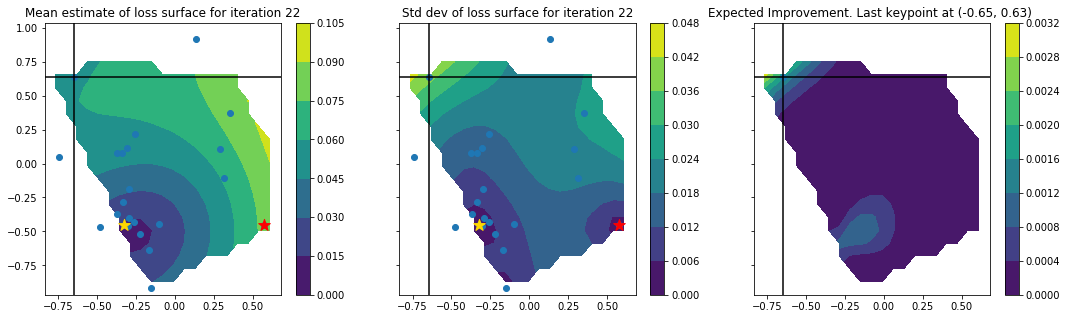

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.94736842105263153)


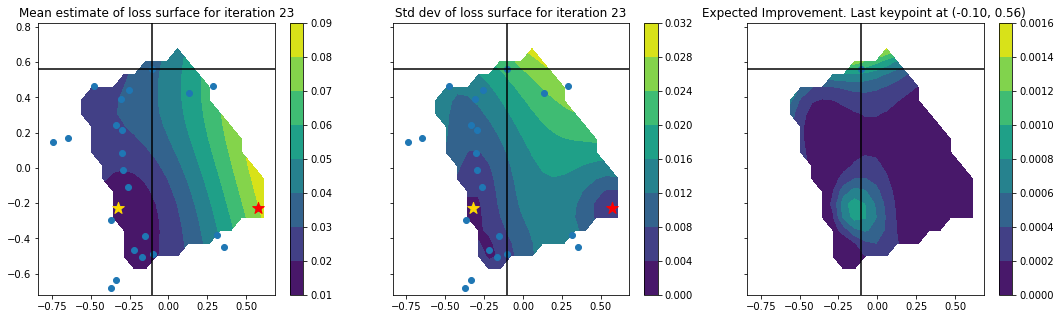

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3}, 0.94736842105263153)


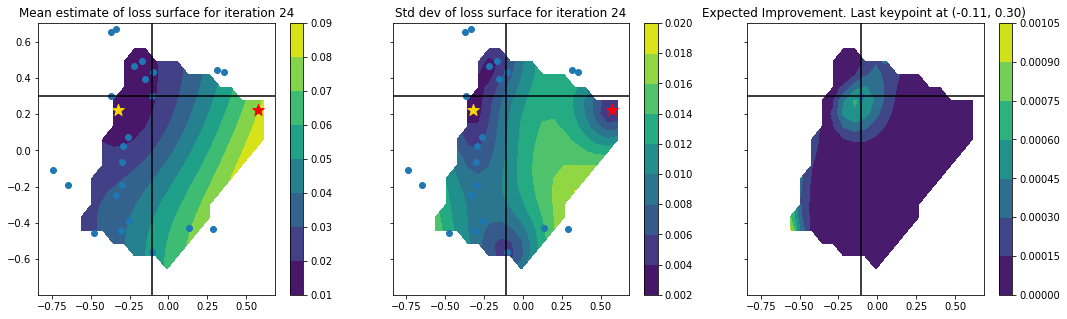

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.98245614035087714)


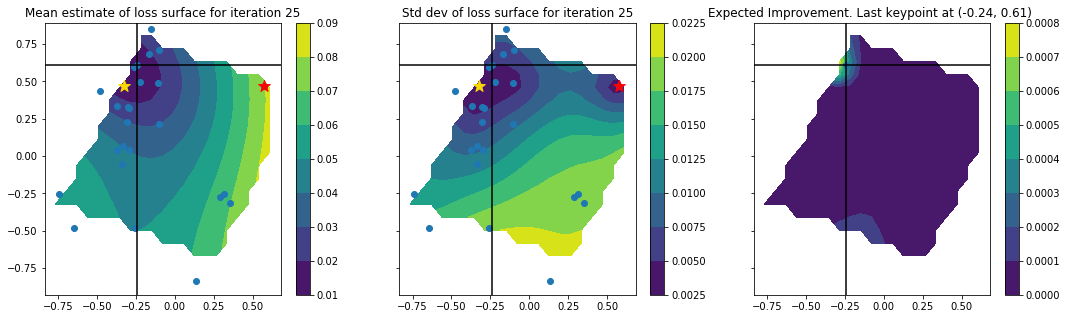

('sample point:', {'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.97368421052631582)


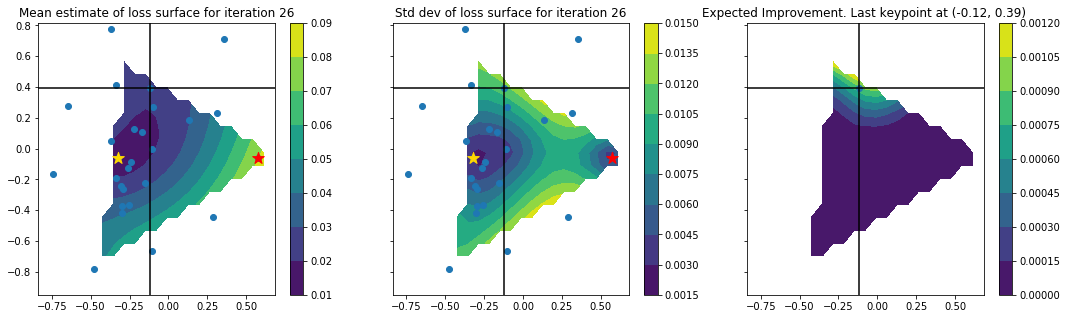

('sample point:', {'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4}, 0.96491228070175439)


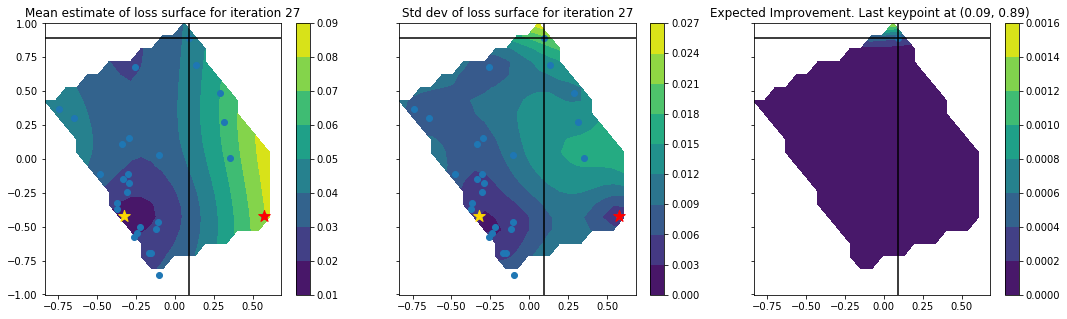

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2}, 0.92105263157894735)


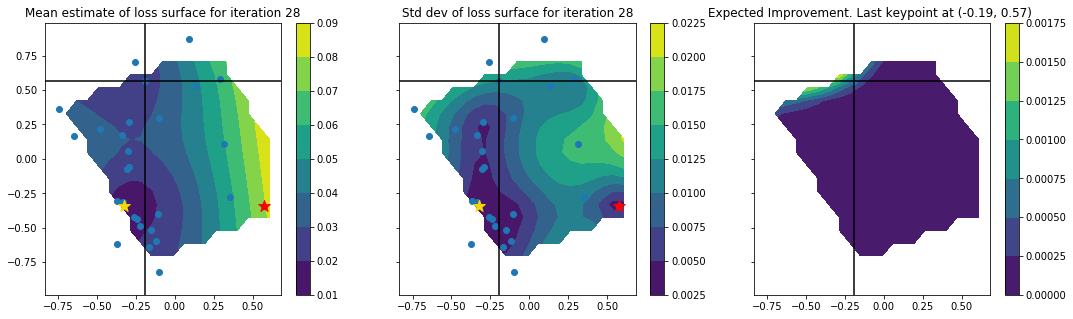

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 3}, 0.97368421052631582)


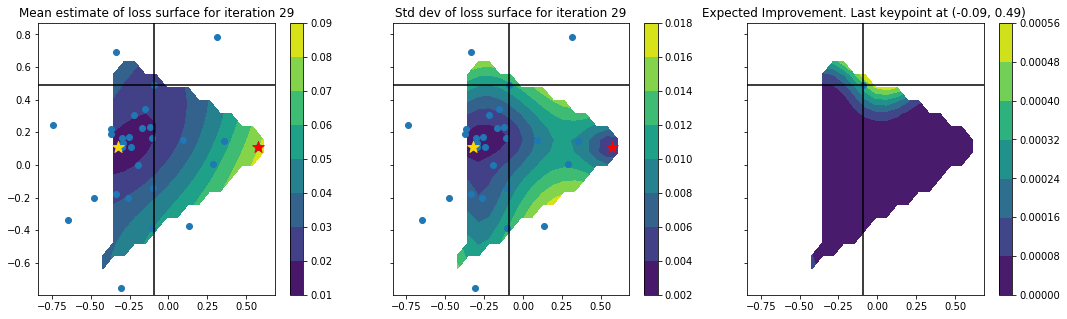

('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}, 0.98245614035087714)


In [20]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=30)

In [21]:
idx = np.argmin(yp) 
print "best:", yp[idx,0], "acc:", (1.0 - yp[idx,0]), " is at:", xp[idx]
print "    ", param_translator({"sample": xp[idx]})

best: 0.00877192982456 acc: 0.991228070175  is at: [ 0.99753869  0.65637509  0.36334721  0.71528622]
     {'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4}


In [16]:
opt = bayopt.BayesianOptimizer(n_params=4,
                               initial_samples=3,
                               proposer=bayopt.MontoCarloDescentProposer(
                                       acquisition_func=bayopt.expected_improvement,
                                       n_params=4),
                               callback=graph)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2}, 0.92105263157894735)
('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.96491228070175439)
('sample point:', {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2}, 0.92105263157894735)


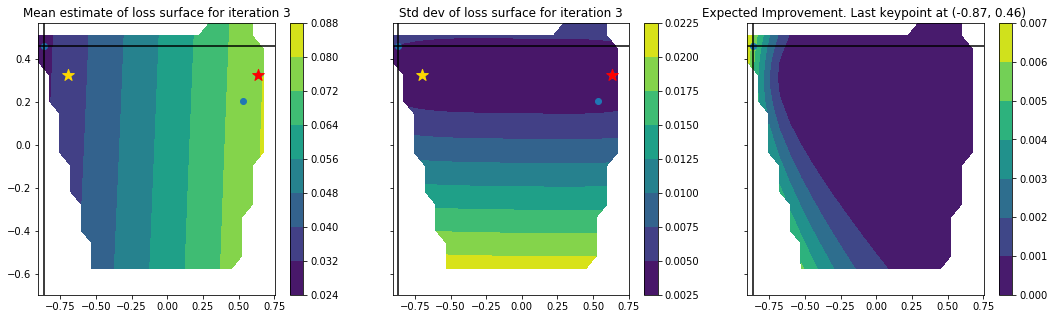

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


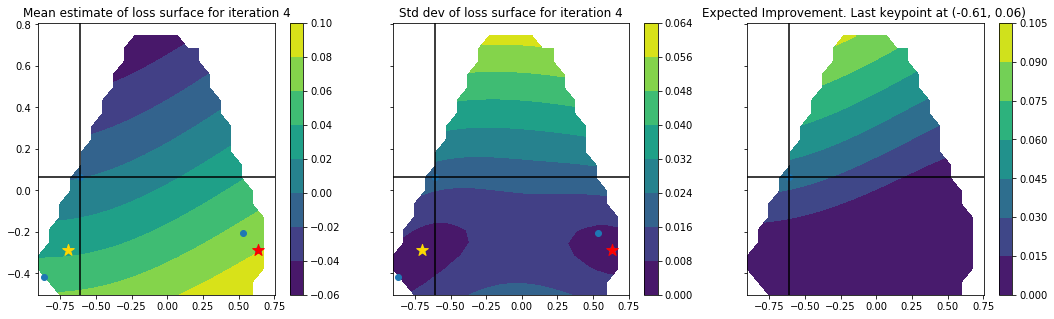

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.92105263157894735)


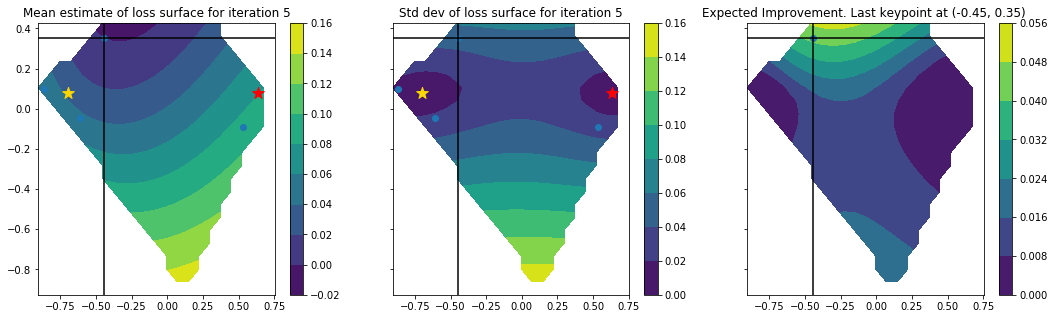

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.96491228070175439)


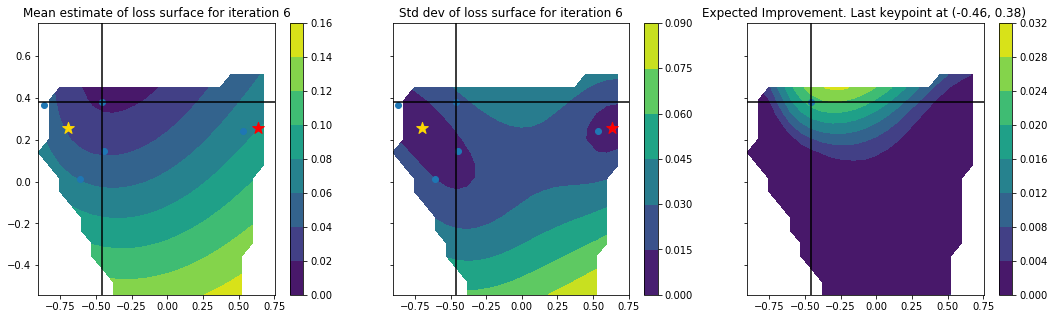

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.93859649122807021)


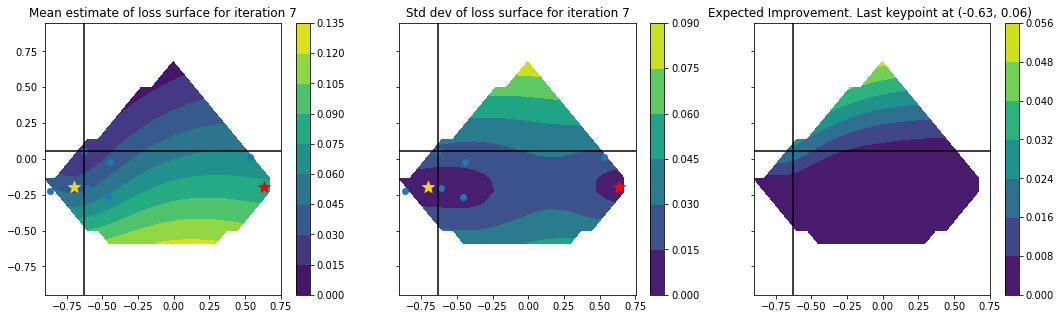

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.96491228070175439)


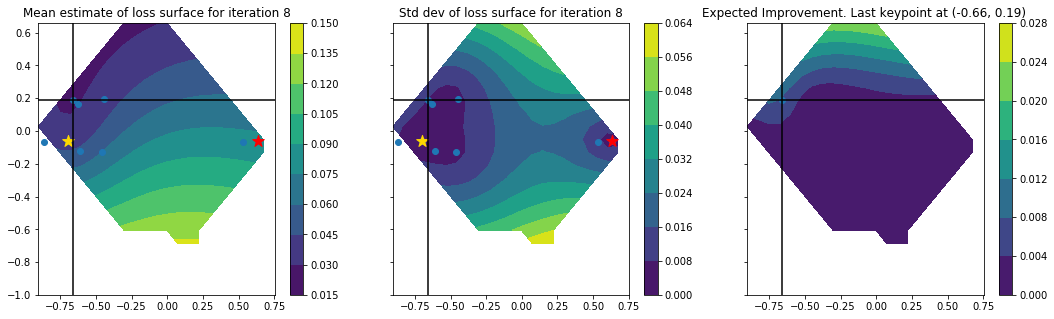

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.91228070175438591)


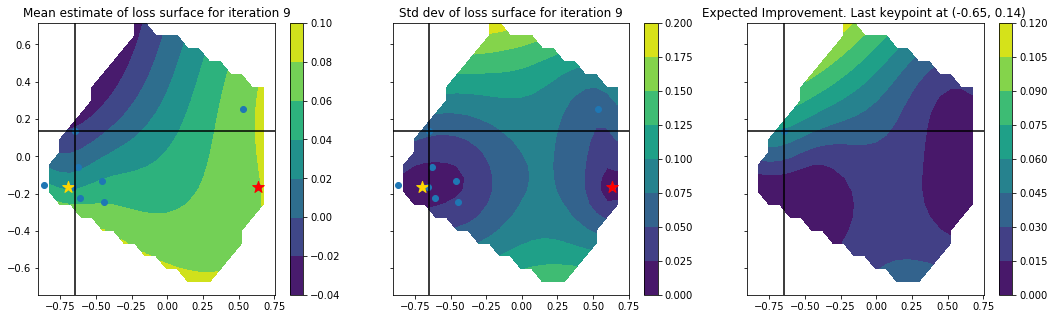

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


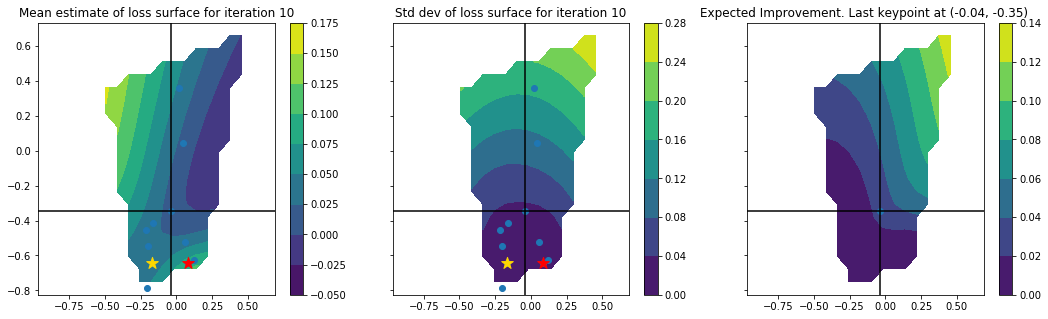

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.96491228070175439)


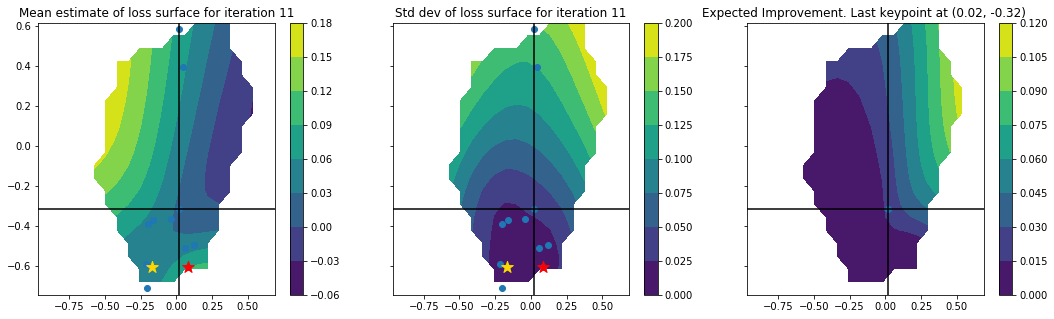

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.92105263157894735)


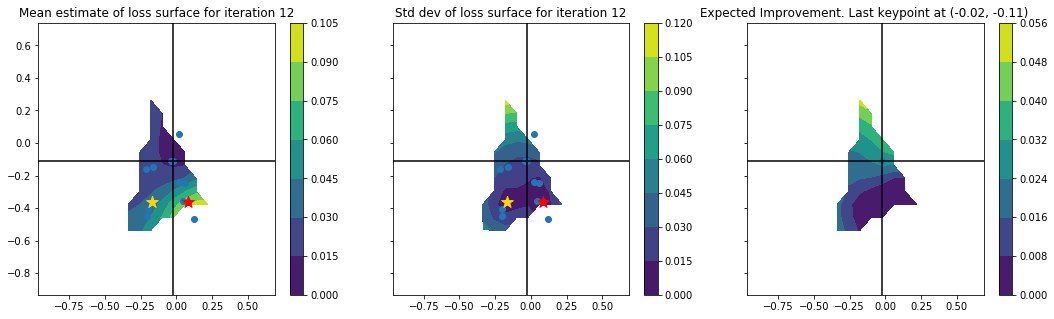

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.96491228070175439)


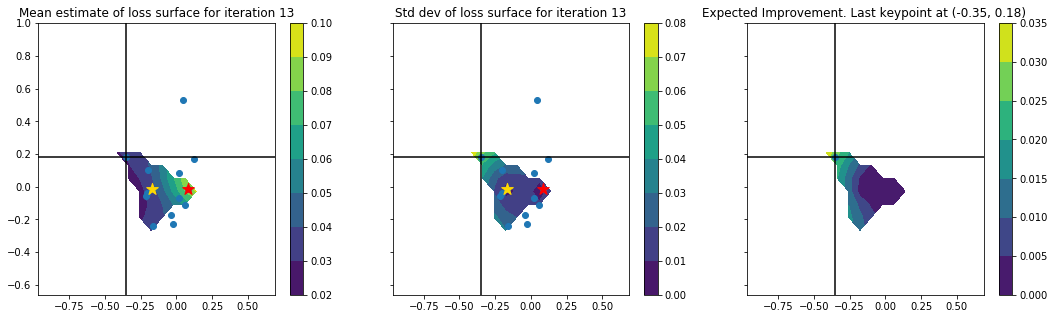

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


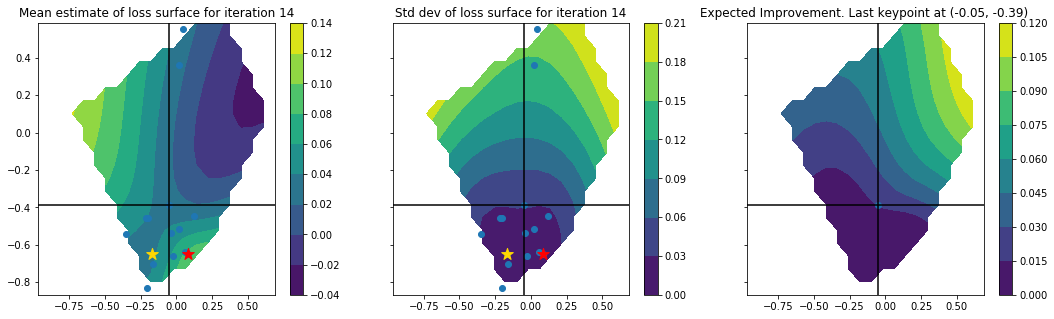

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.91228070175438591)


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.25016931e-05]), 'nit': 6, 'funcalls': 55}
  " state: %s" % convergence_dict)


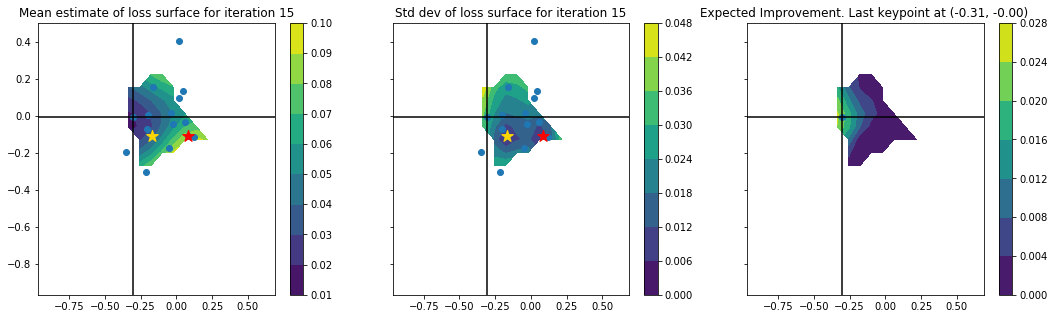

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.93859649122807021)


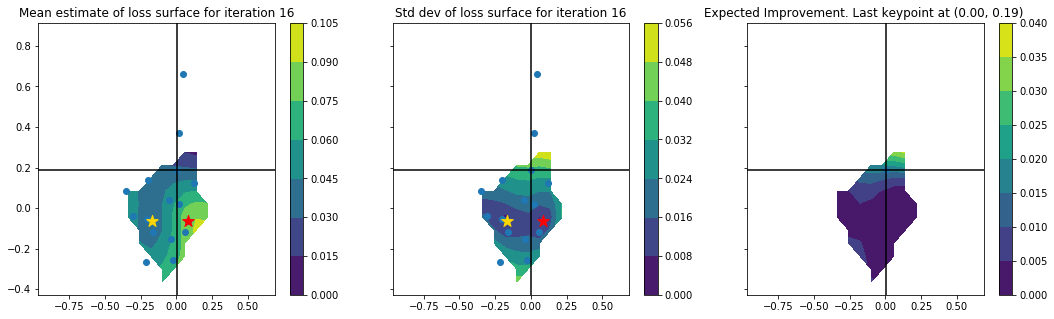

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.92982456140350878)


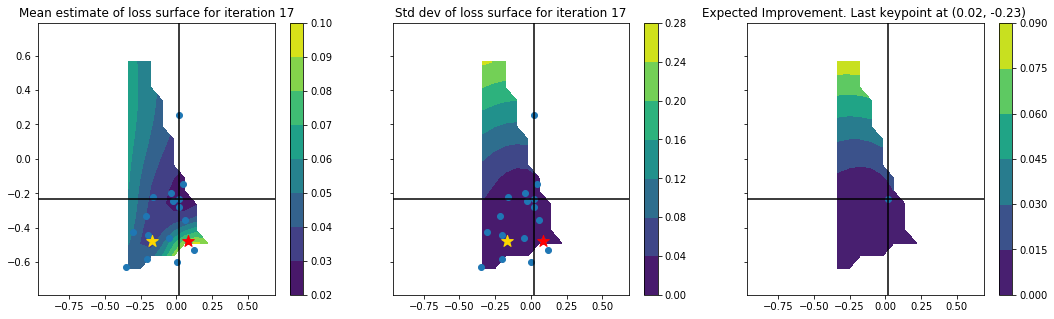

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.88596491228070173)


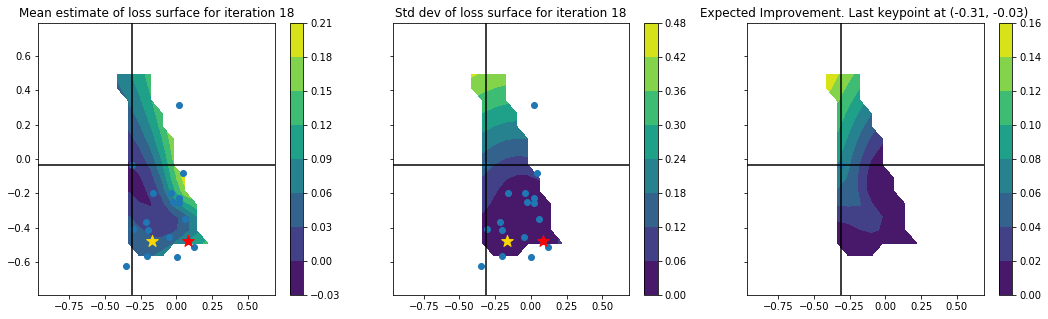

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2}, 0.92105263157894735)


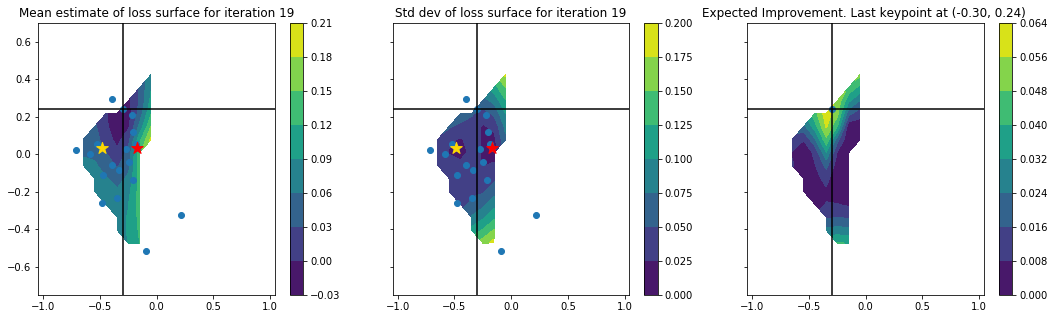

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.95614035087719296)


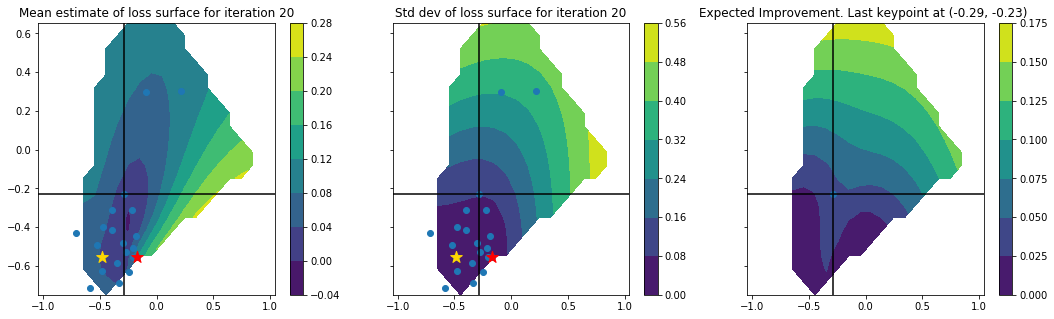

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


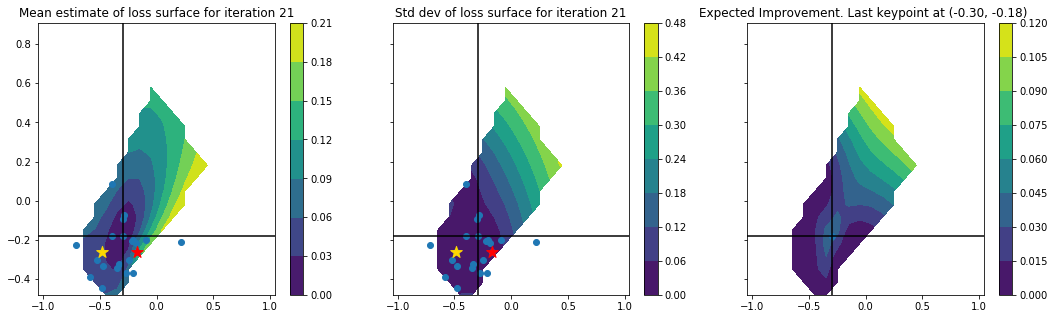

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


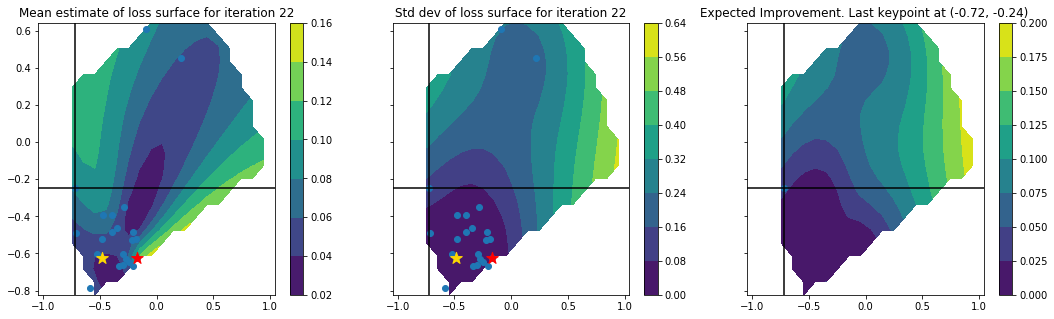

('sample point:', {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2}, 0.94736842105263153)


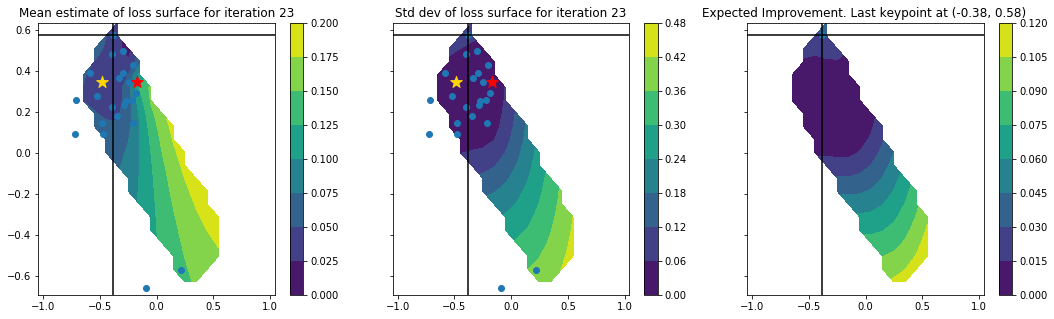

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.95614035087719296)


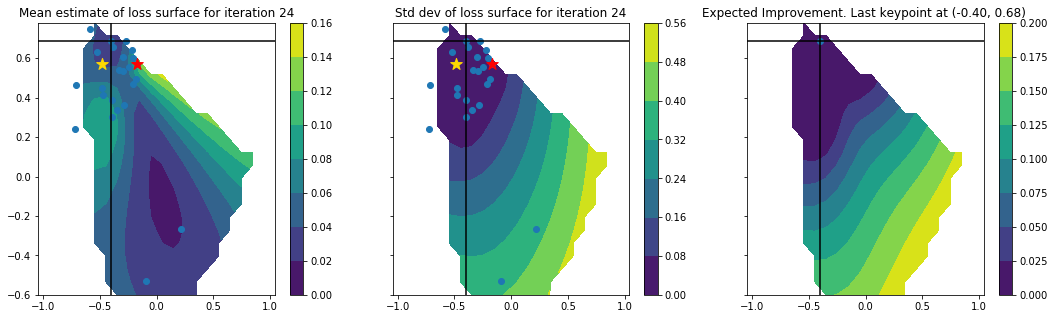

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.95614035087719296)


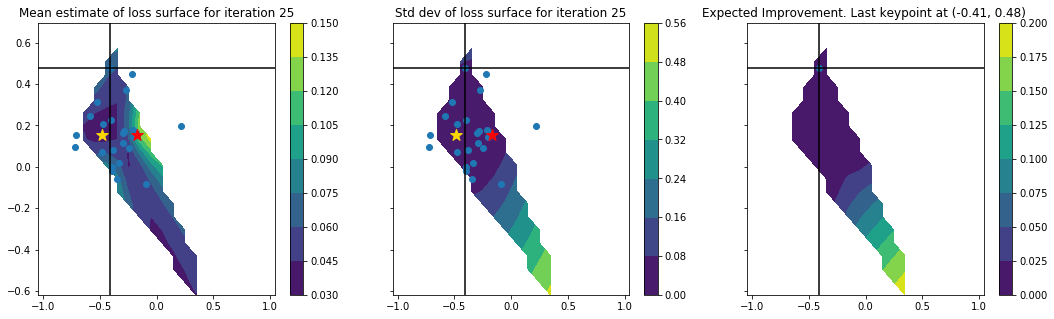

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2}, 0.95614035087719296)


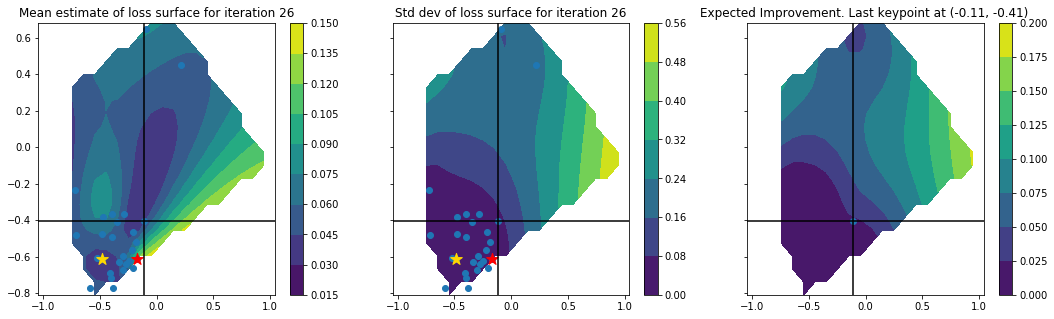

('sample point:', {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.93859649122807021)


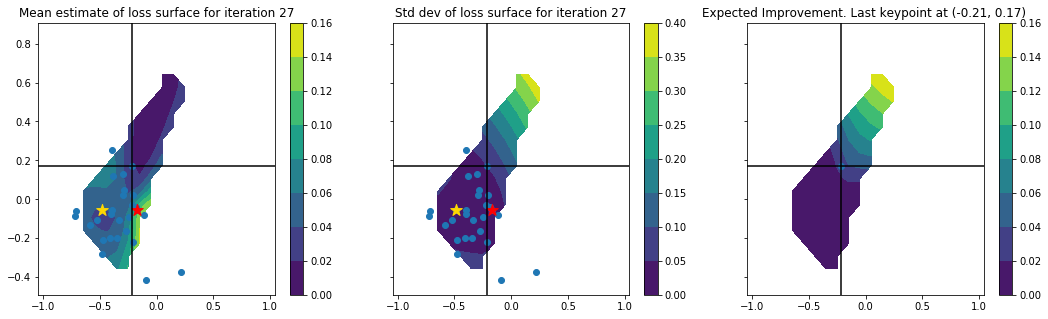

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.97368421052631582)


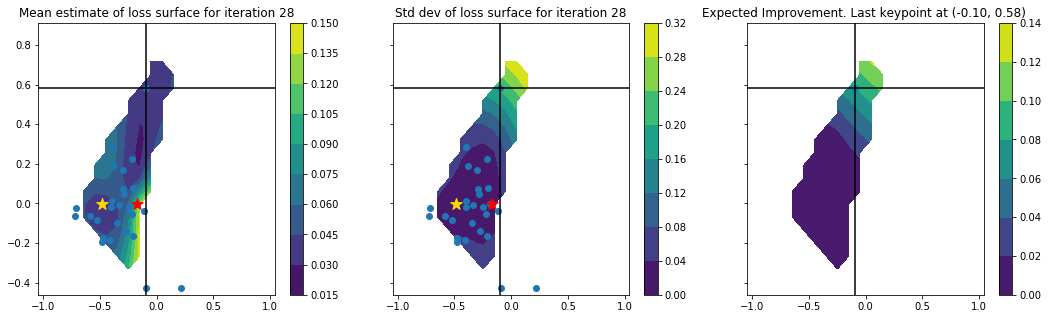

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4}, 0.95614035087719296)


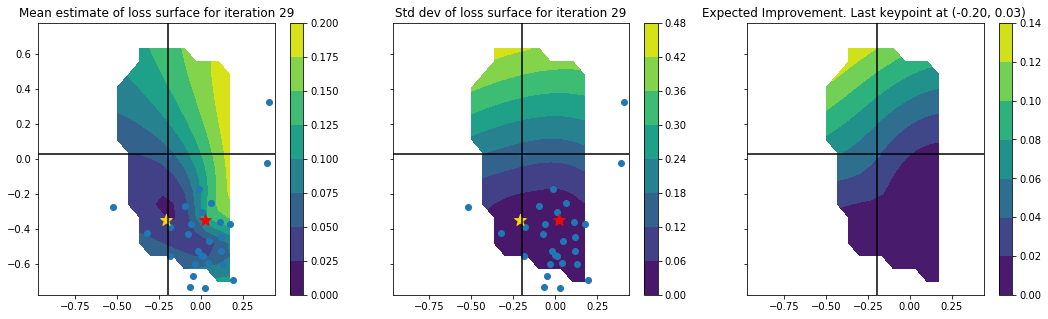

('sample point:', {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}, 0.99122807017543857)


In [19]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=30)

In [25]:
idx = np.argmin(yp) 
print "best:", yp[idx,0], "acc:", (1.0 - yp[idx,0]), " is idx:", idx
print "    ", xp[idx]
print "    ", param_translator({"sample": xp[idx]})

best: 0.00877192982456 acc: 0.991228070175  is idx: 29
     [ 0.64569875  0.13479978  0.93667391  0.49899838]
     {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3}


In [19]:
callback=graph

proposer = bayopt.MontoCarloProposer(acquisition_func=bayopt.expected_improvement,
                                     n_params=4)
modeller = bayopt.GuassianProcess25Model(proposer=proposer,
                                         callback=callback)

opt = bayopt.BayesianOptimizer(n_params=4,
                               initial_samples=3,
                               proposer=proposer,
                               modeller=modeller,                               
                               callback=graph)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


sample point: {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.938596491228
sample point: {'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 3} 0.956140350877
sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.956140350877


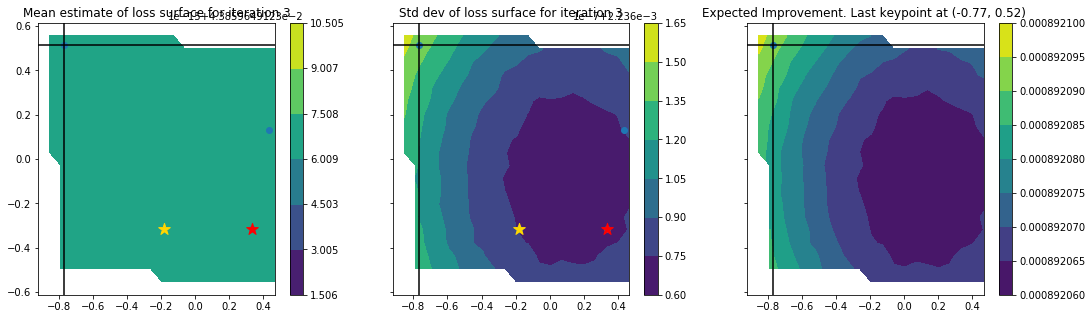

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404


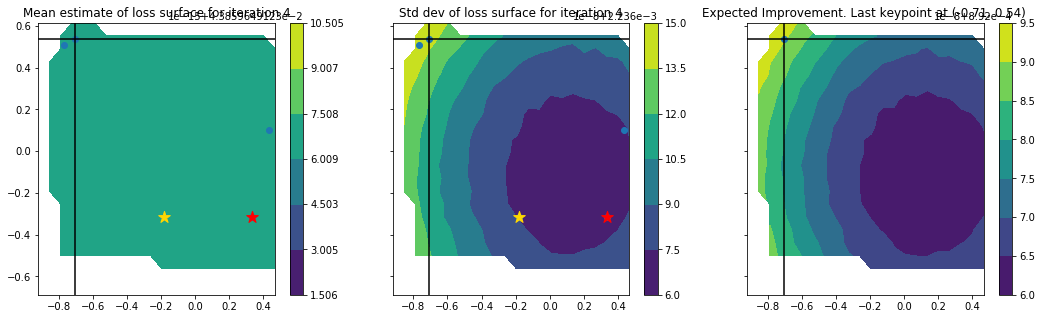

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404


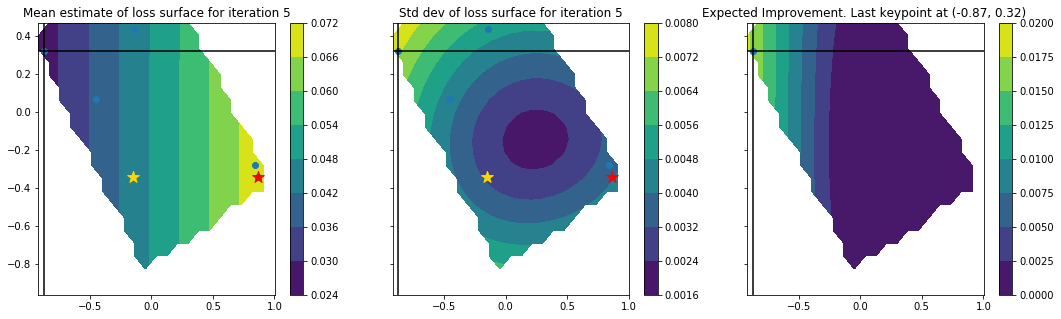

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.929824561404


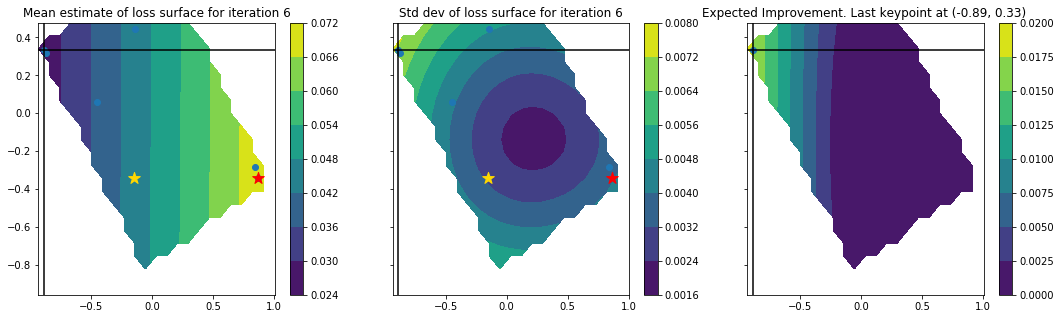

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


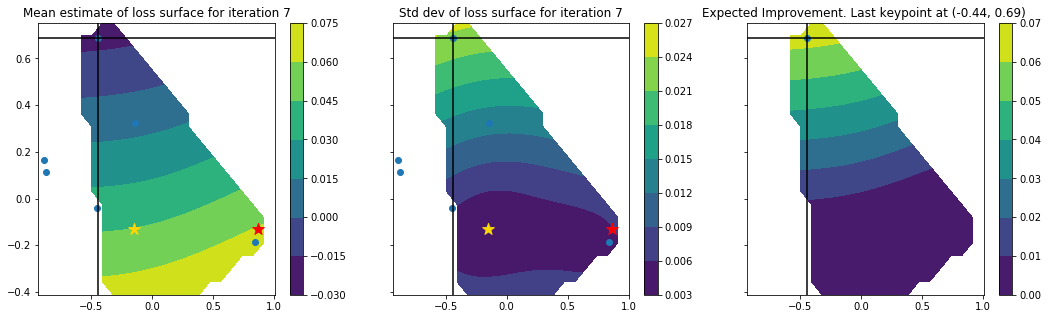

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.956140350877


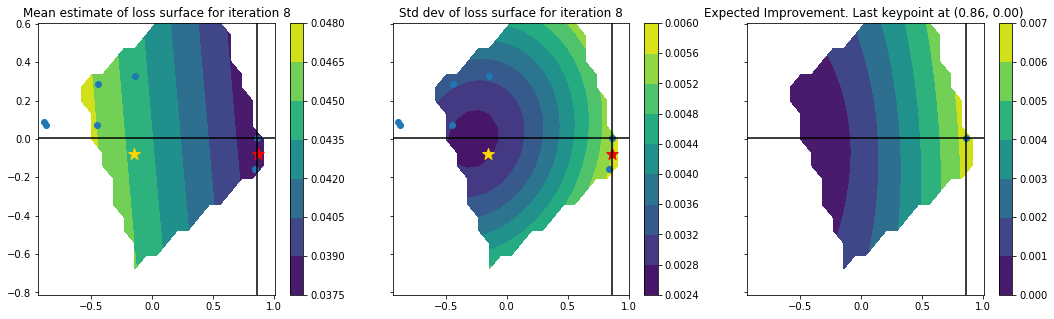

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404


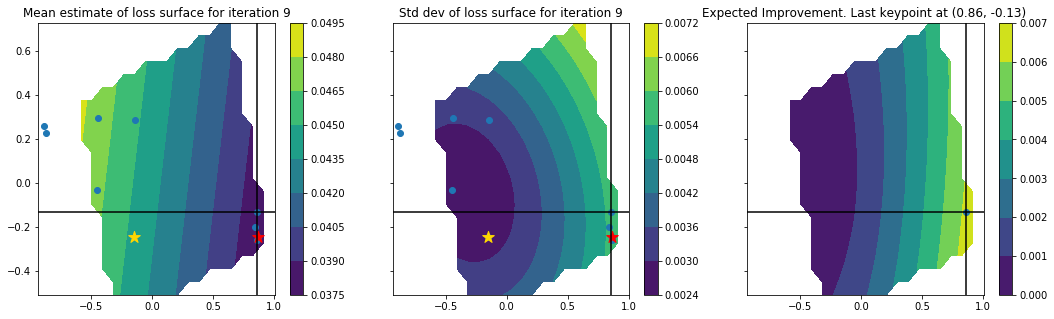

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404


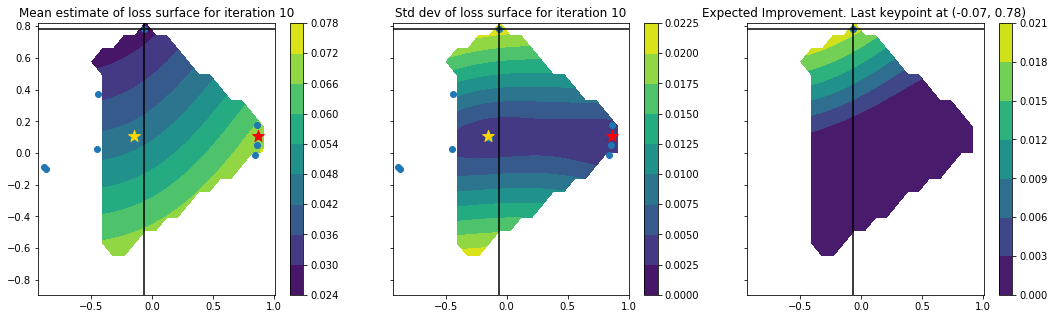

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


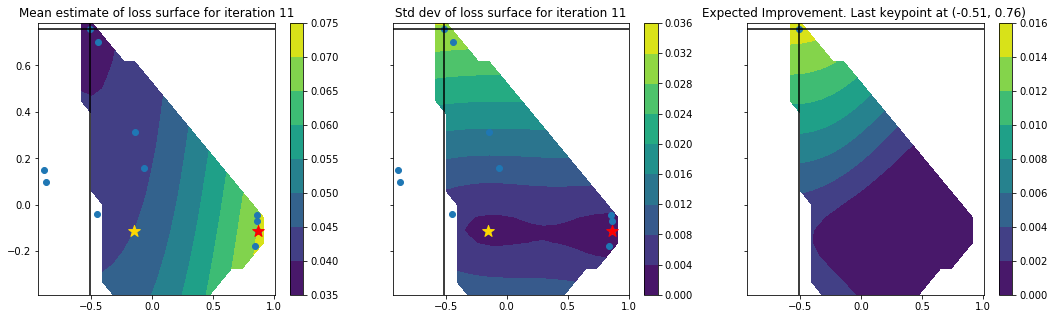

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.938596491228


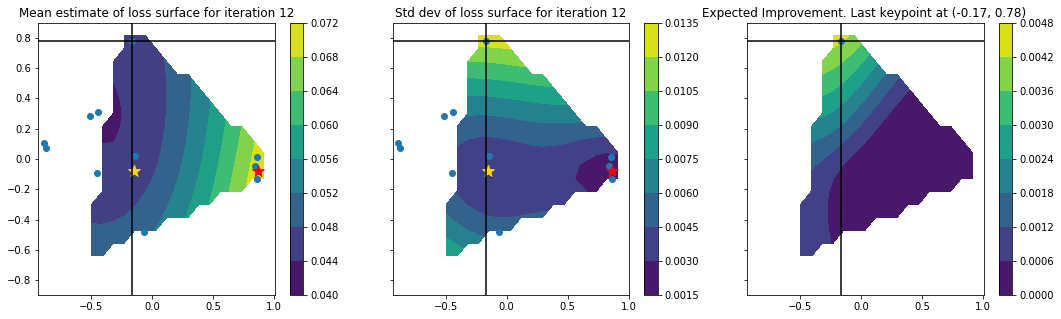

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.929824561404


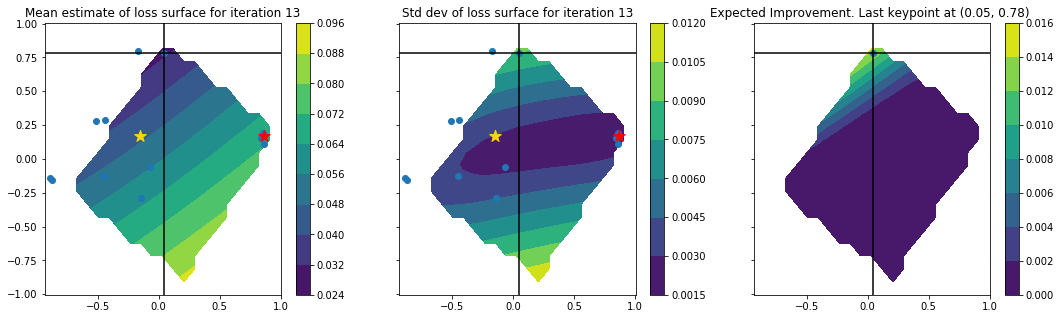

sample point: {'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.929824561404


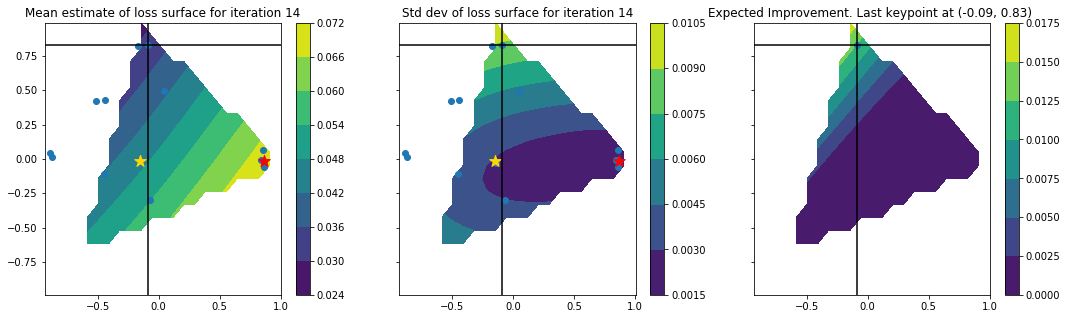

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.938596491228


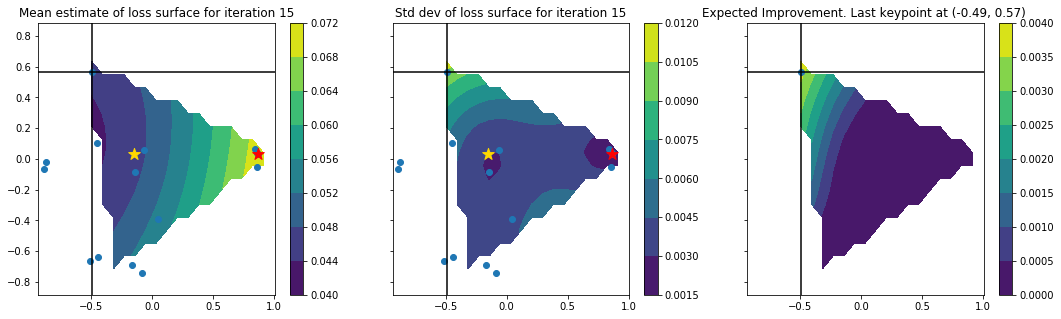

sample point: {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.938596491228


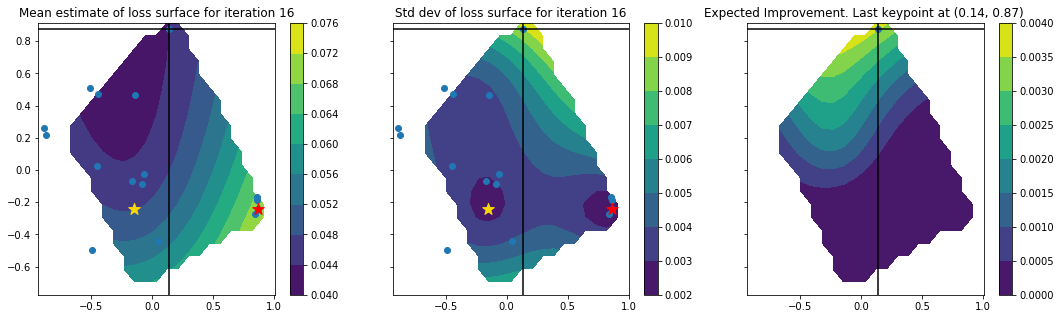

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4} 0.956140350877


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.22389142e-05]), 'nit': 4, 'funcalls': 47}
  " state: %s" % convergence_dict)


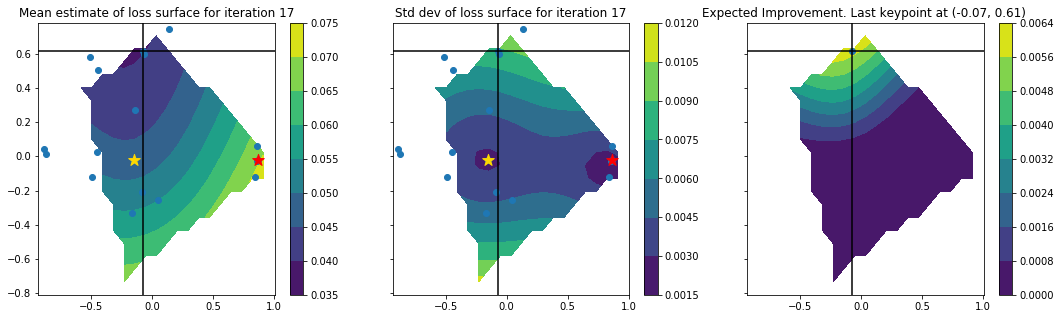

sample point: {'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.938596491228


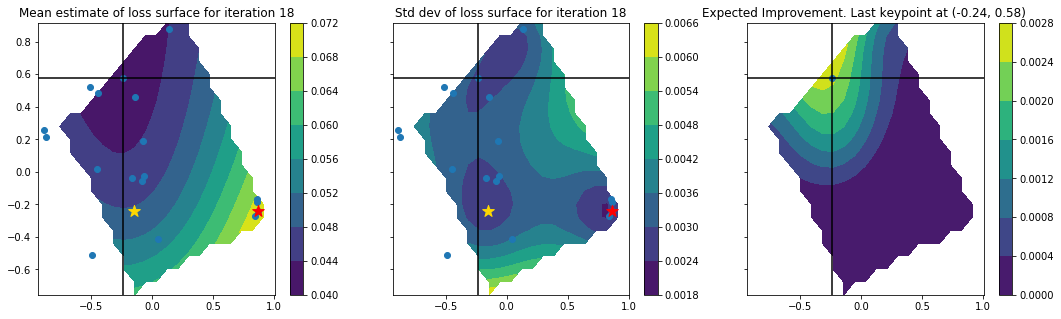

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


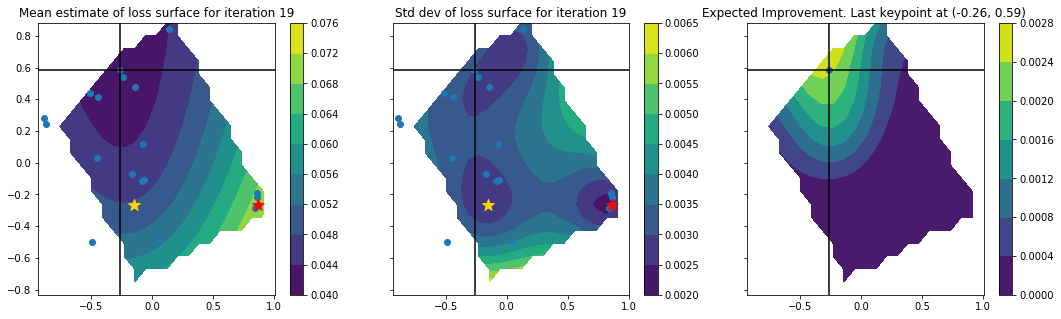

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4} 0.947368421053


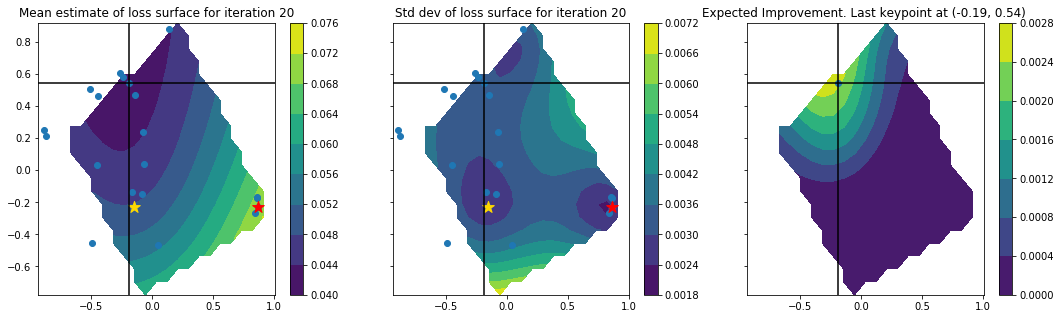

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4} 0.938596491228


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.89887800e-05]), 'nit': 6, 'funcalls': 51}
  " state: %s" % convergence_dict)


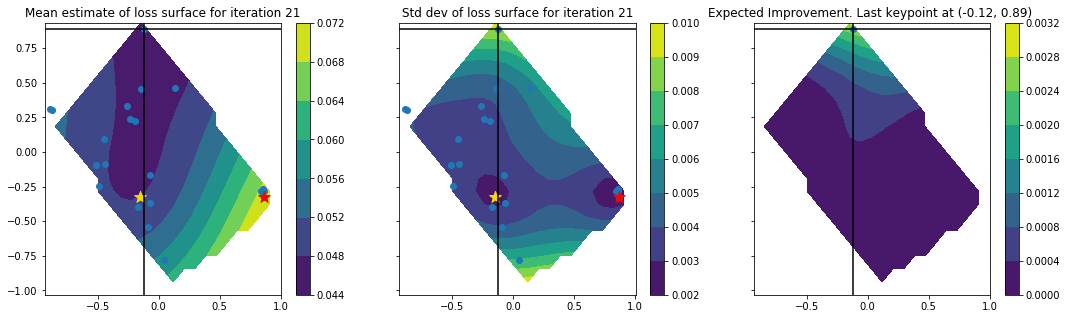

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.947368421053


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.04496004e-05]), 'nit': 3, 'funcalls': 47}
  " state: %s" % convergence_dict)


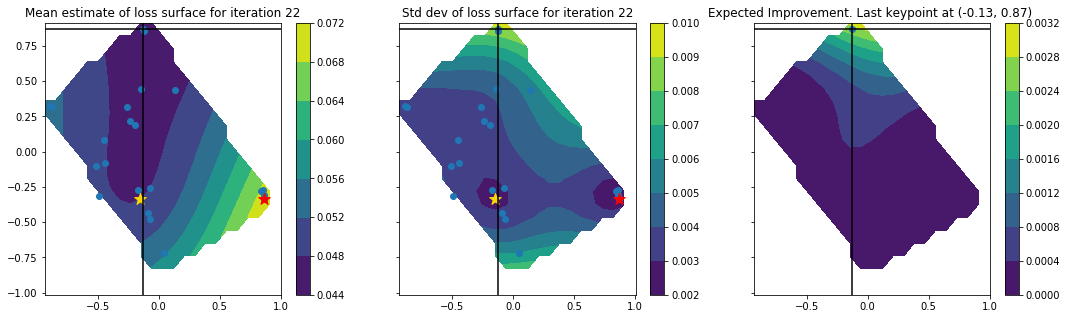

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.956140350877


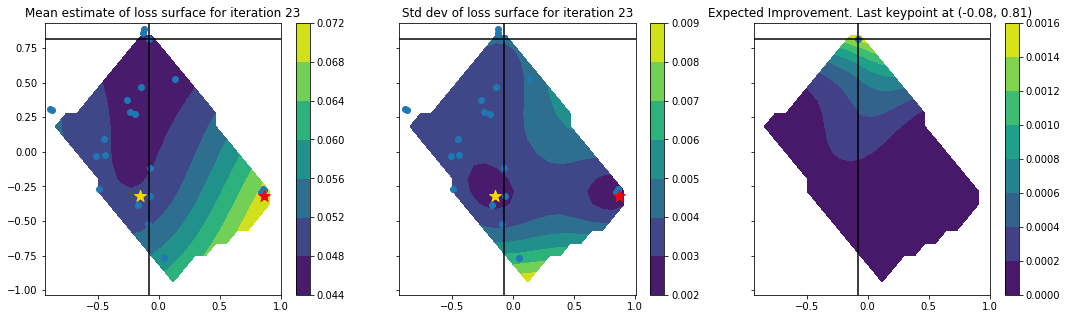

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.929824561404


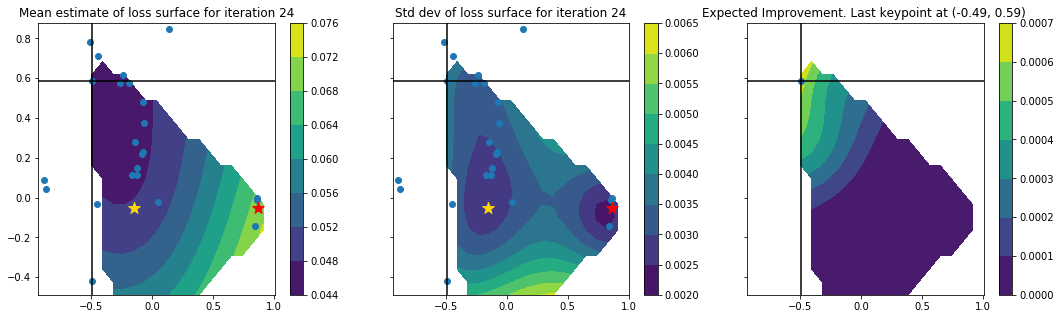

sample point: {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


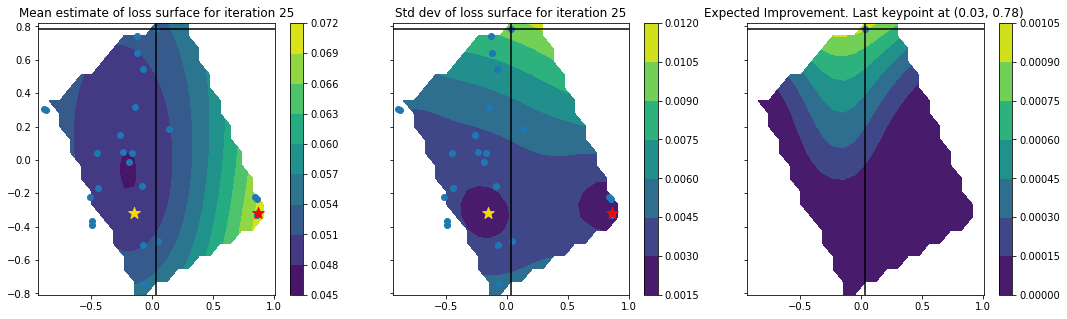

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2} 0.921052631579


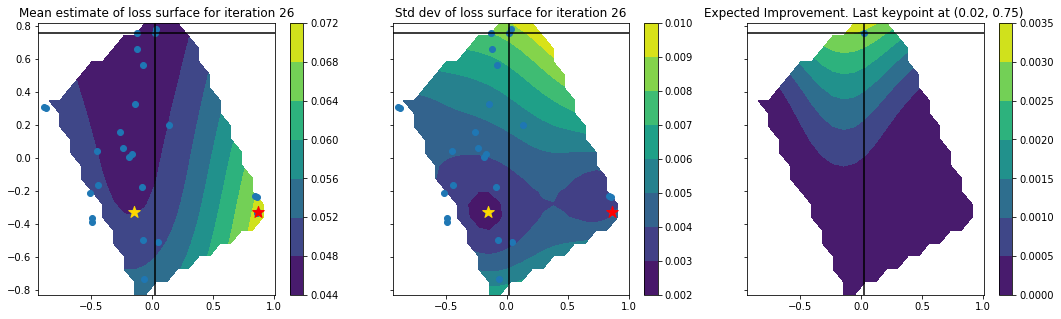

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404


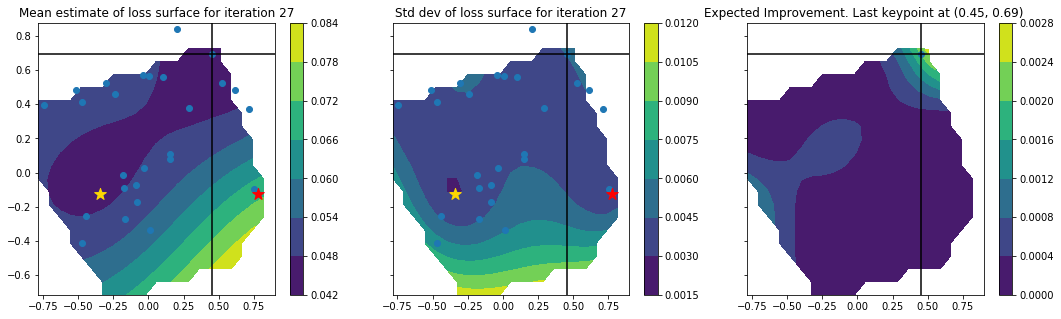

sample point: {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4} 0.947368421053


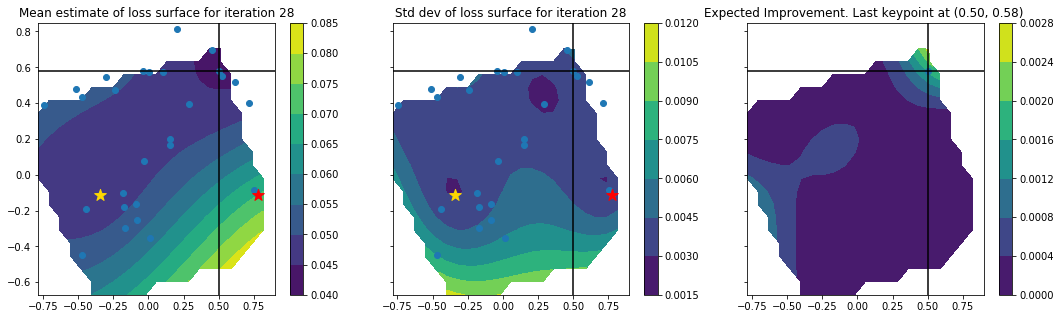

sample point: {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.956140350877


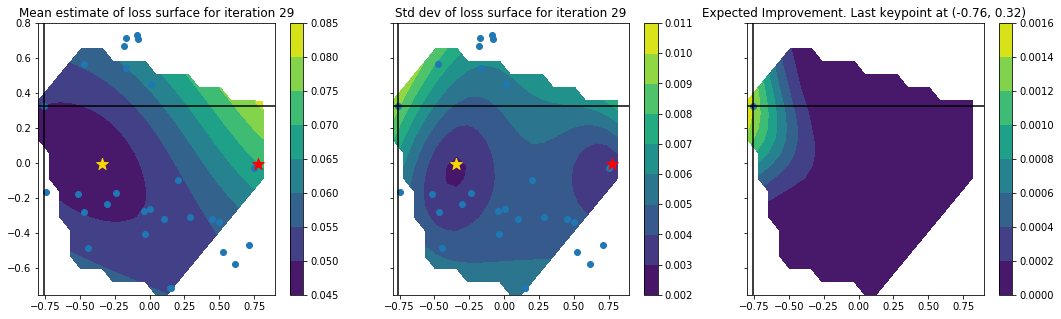

sample point: {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.929824561404


In [20]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=30)

In [21]:
idx = np.argmin(yp) 
print "best:", yp[idx,0], "acc:", (1.0 - yp[idx,0]), " is idx:", idx
print "    ", xp[idx]
print "    ", param_translator({"sample": xp[idx]})

best: 0.0438596491228 acc: 0.956140350877  is idx: 1
     [ 0.50786391  0.68390299  0.39878438  0.18887889]
     {'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 3}


In [17]:
################################## MIXTURE ##############################
n_params=4
callback=graph
acquisition_func=bayopt.expected_improvement

# rand
modeller_random = bayopt.RandomModel(n_params=n_params)

# normal GP with monto carla sampling
proposer = bayopt.MontoCarloProposer(acquisition_func=acquisition_func,
                                     n_params=n_params)
modeller_norm = bayopt.GuassianProcessModel(proposer=proposer,     
                                            callback=callback)

# 25% model with monto carlo sampling
modeller_25 = bayopt.GuassianProcess25Model(proposer=proposer,     
                                            callback=callback)

# normal GP model with local best descent 
proposer_decsent=bayopt.MontoCarloDescentProposer(acquisition_func=acquisition_func,
                                                  n_params=n_params)
modeller_descent = bayopt.GuassianProcessModel(proposer=proposer_decsent,     
                                               callback=callback,
                                               tag="gp(descent)")


# finally the stacked version of the above models
modeller = bayopt.StackedDecisionModel()

modeller.add(1, modeller_random)
modeller.add(5, modeller_norm)
modeller.add(5, modeller_descent)
modeller.add(5, modeller_25)

opt = bayopt.BayesianOptimizer(n_params=4,
                               initial_samples=3,
                               modeller=modeller)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


random : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3} 0.938596491228
random : {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.947368421053
random : {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.912280701754


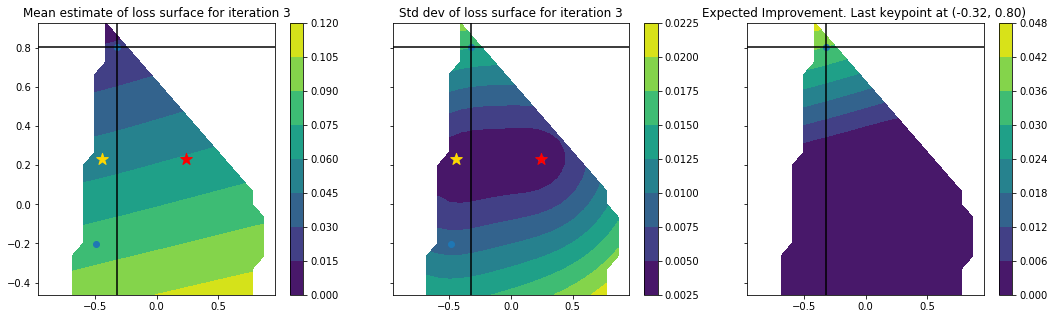

gp(norm) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.938596491228


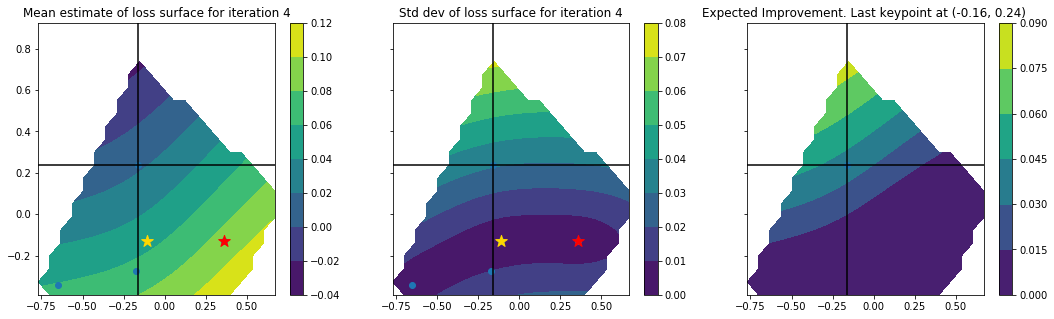

gp(descent) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.938596491228


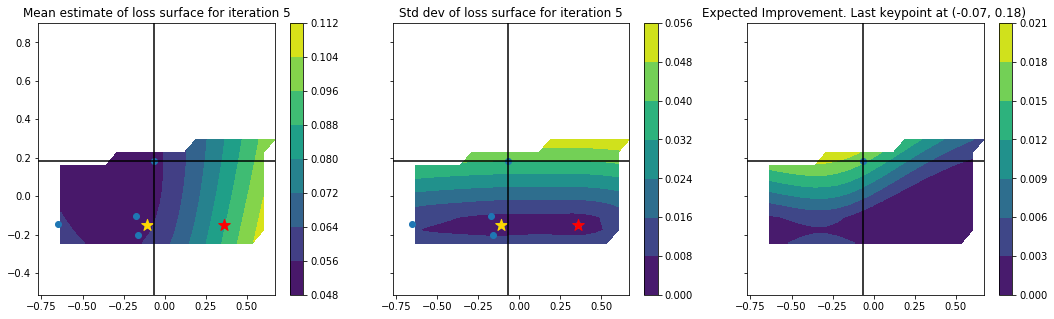

gp(descent) : {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.956140350877


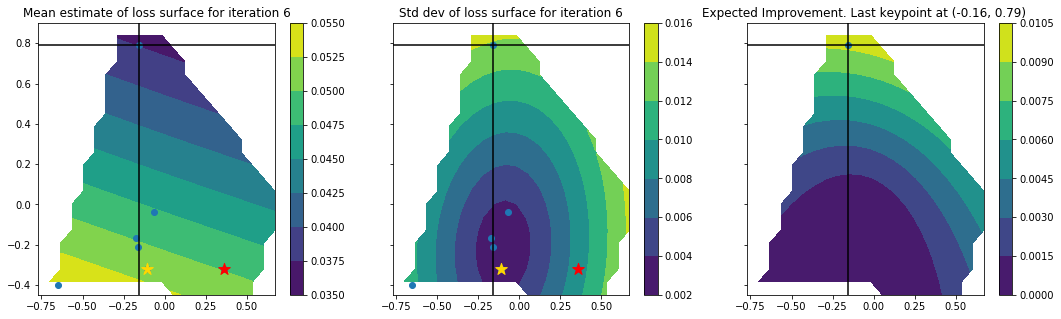

gp(25%) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


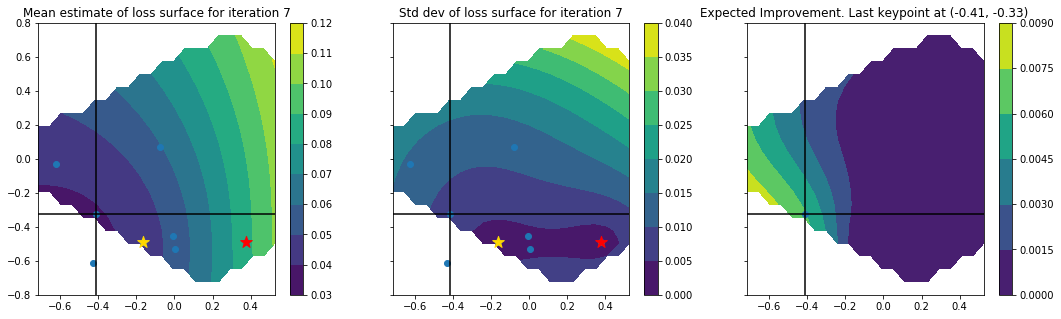

gp(descent) : {'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3} 0.956140350877


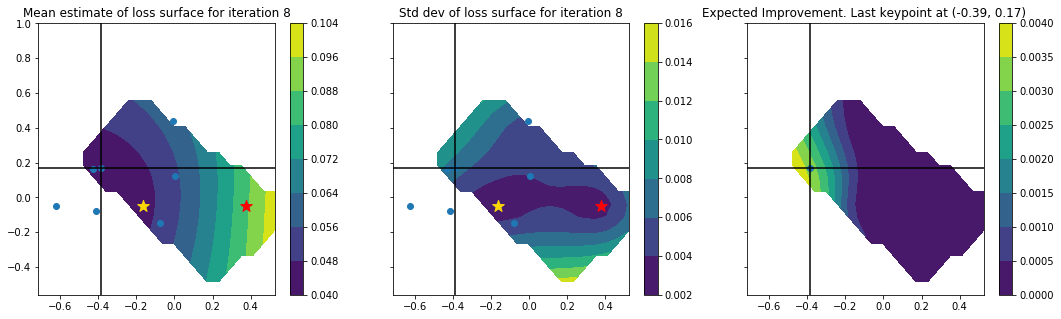

gp(descent) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.947368421053


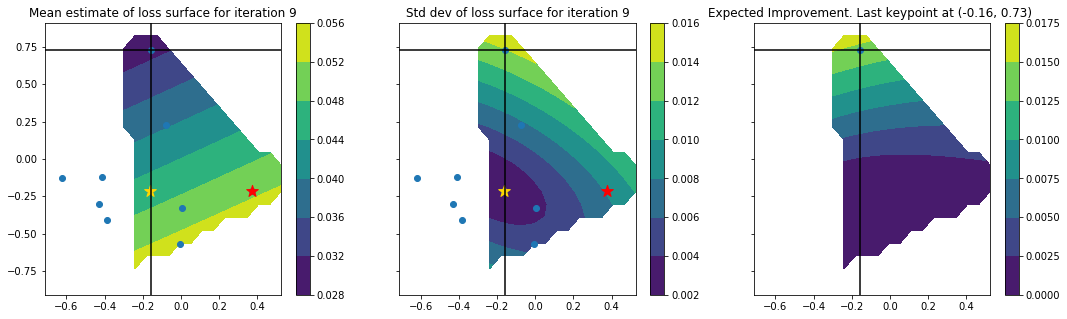

gp(25%) : {'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4} 0.947368421053


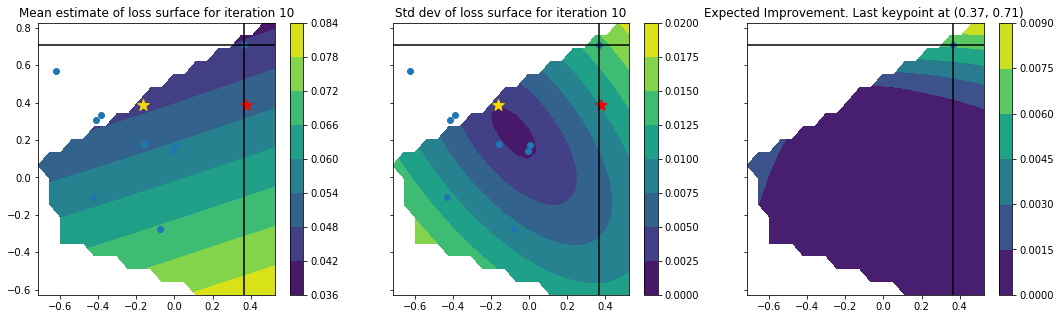

gp(25%) : {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 2} 0.912280701754


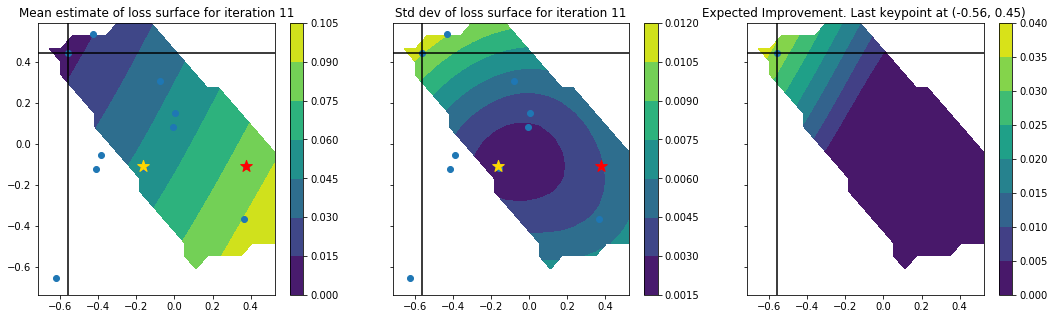

gp(25%) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 2} 0.929824561404
random : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3} 0.964912280702


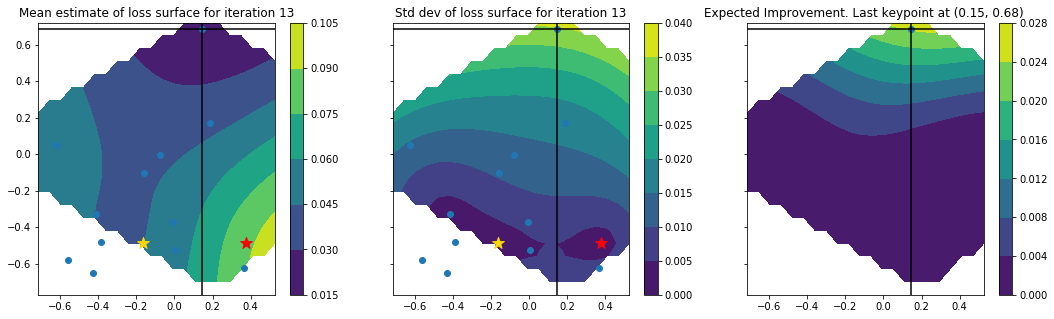

gp(norm) : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.938596491228


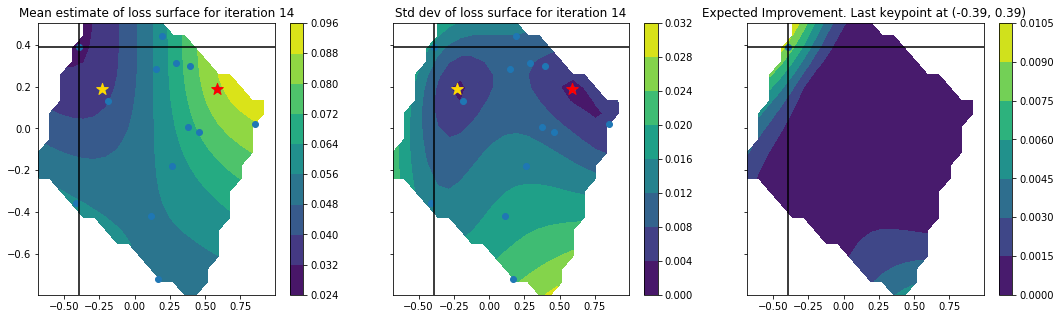

gp(descent) : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3} 0.947368421053


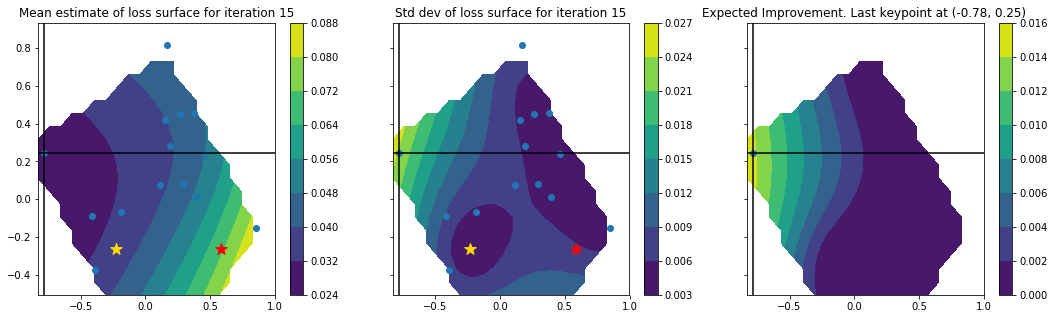

gp(25%) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.964912280702


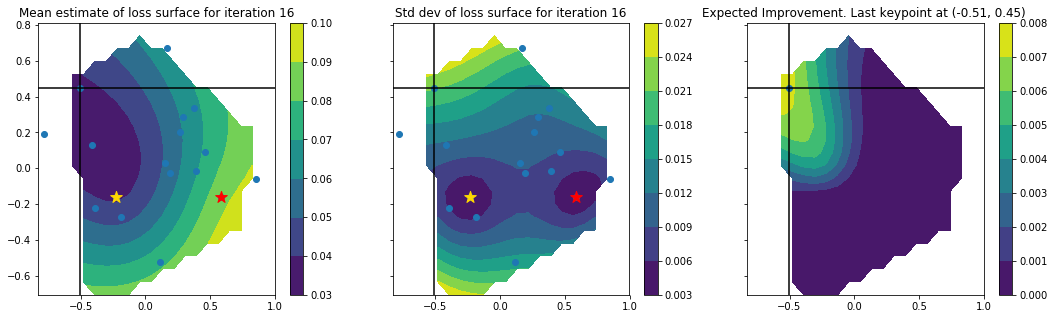

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3} 0.947368421053


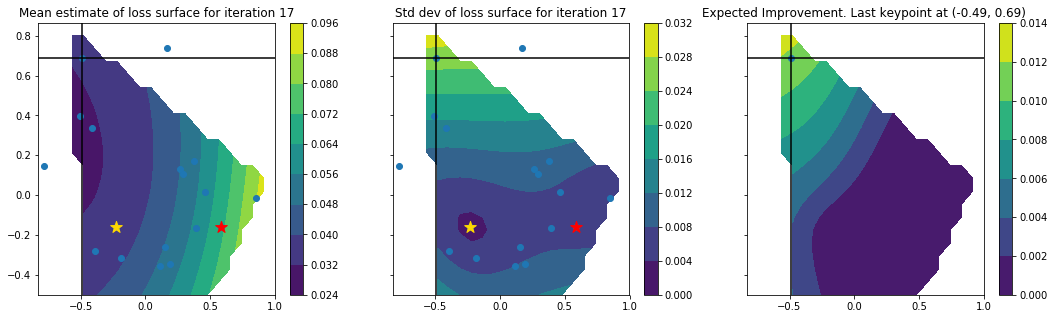

gp(25%) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.964912280702


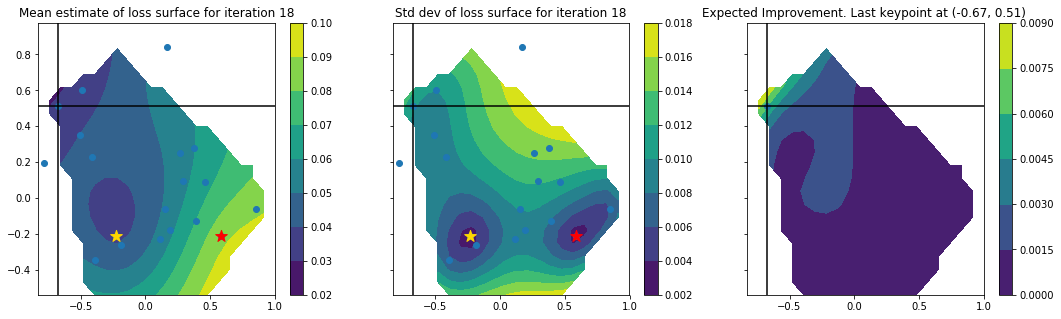

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.964912280702


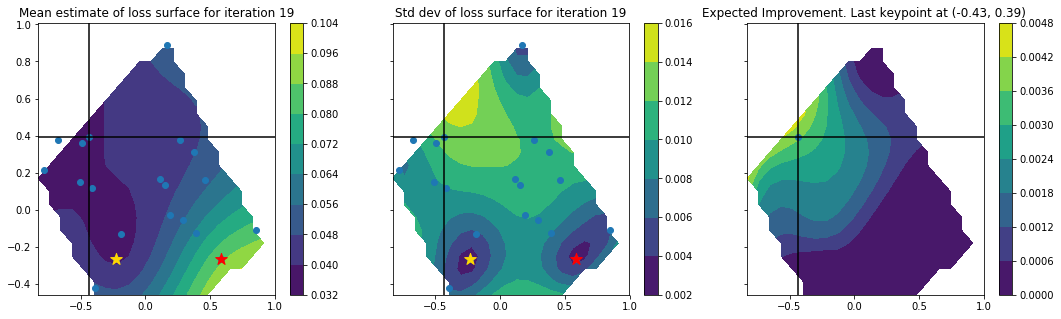

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.964912280702


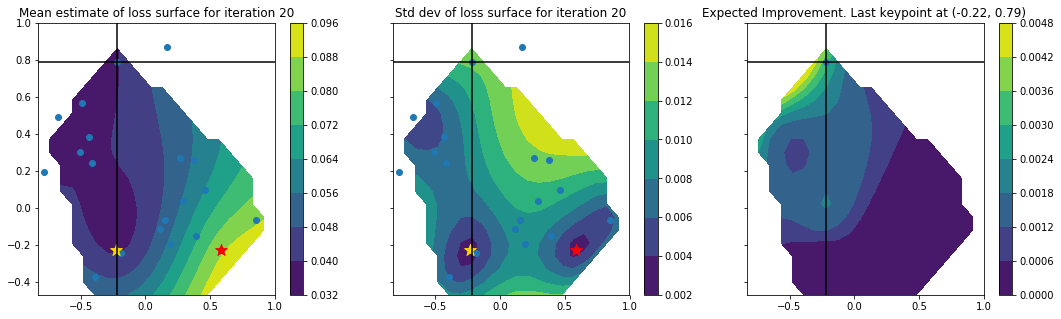

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.973684210526


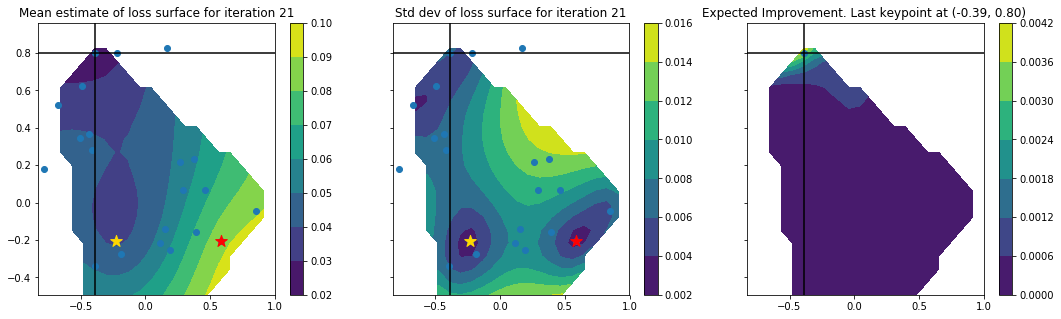

gp(descent) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 5} 0.982456140351


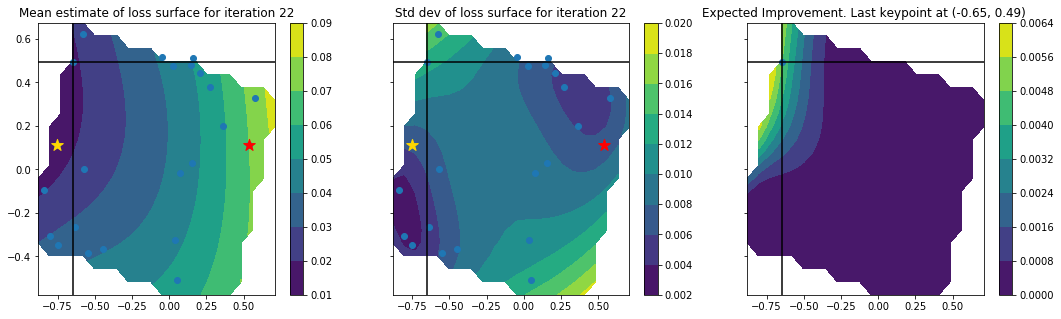

gp(25%) : {'max_features': 'auto', 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.964912280702


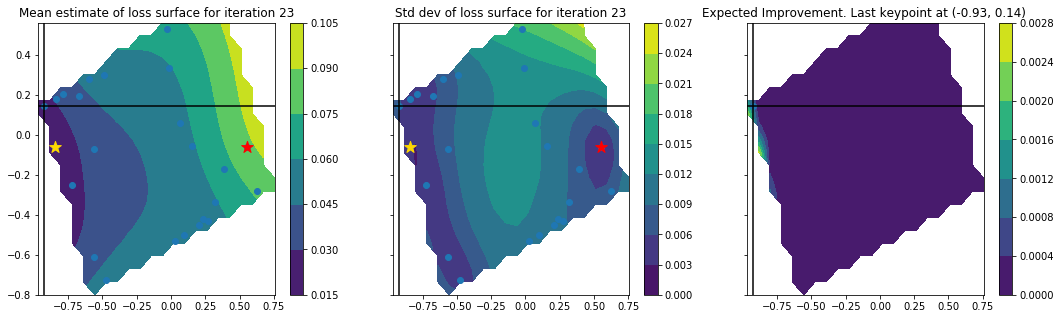

gp(descent) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 5} 0.956140350877


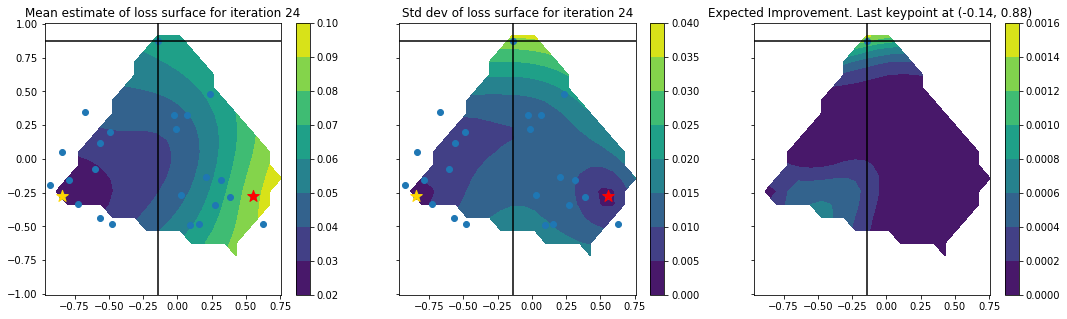

gp(norm) : {'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4} 0.973684210526


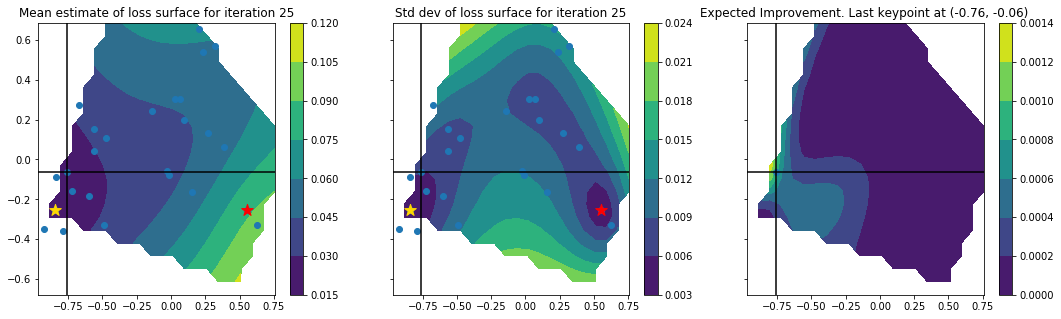

gp(descent) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 5} 0.964912280702


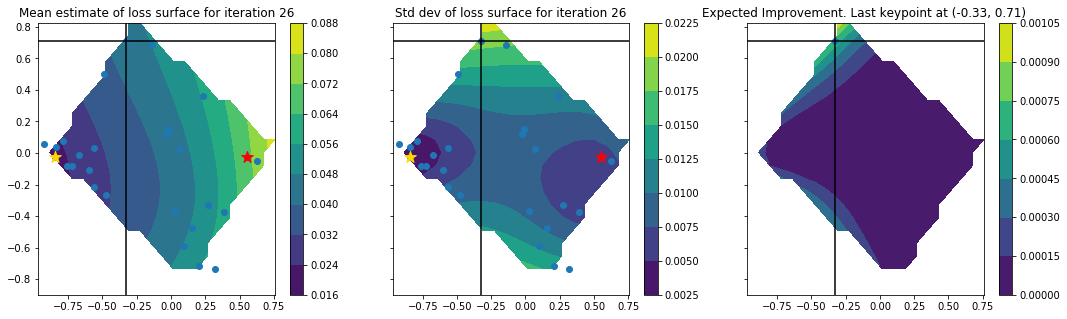

gp(25%) : {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


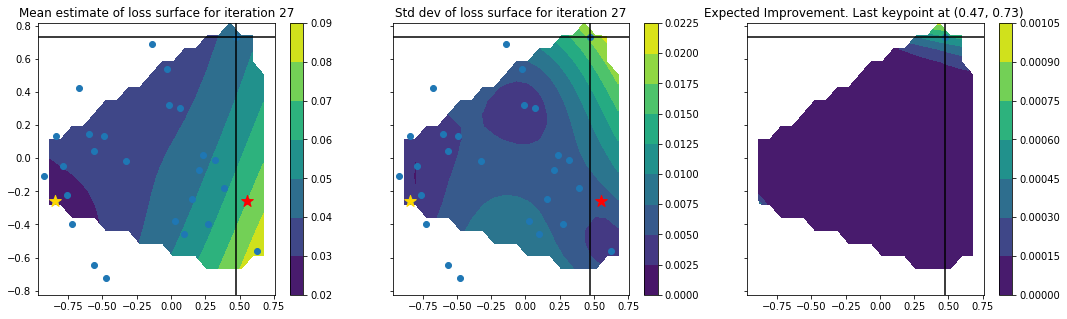

gp(25%) : {'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2} 0.964912280702


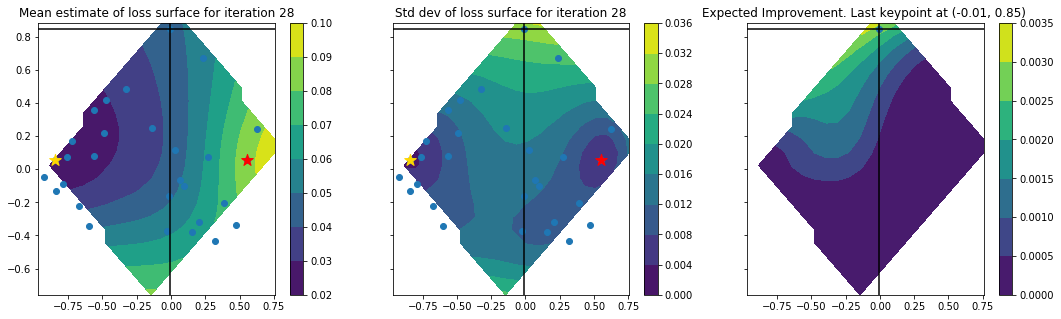

gp(norm) : {'max_features': None, 'bootstrap': False, 'criterion': 'gini', 'max_depth': 4} 0.956140350877


/usr/local/lib/python2.7/dist-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.19579103e-05]), 'nit': 3, 'funcalls': 46}
  " state: %s" % convergence_dict)


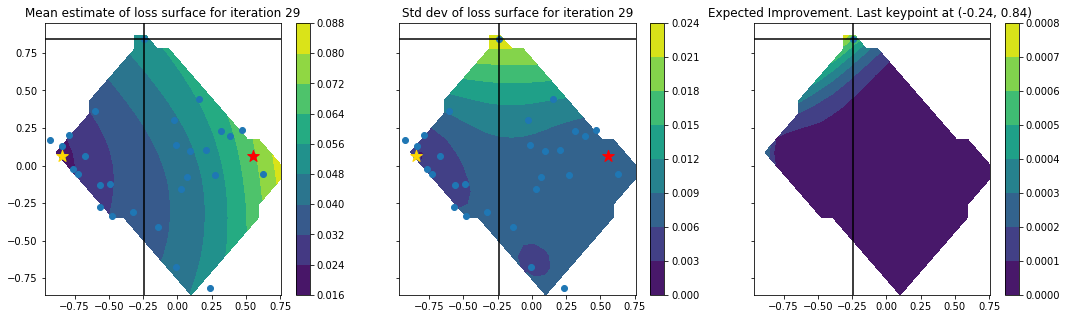

gp(25%) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2} 0.947368421053


In [18]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=30)

In [19]:
idx = np.argmin(yp) 
print "best:", yp[idx,0], "acc:", (1.0 - yp[idx,0]), " is idx:", idx
print "    ", xp[idx]
print "    ", param_translator({"sample": xp[idx]})

best: 0.0175438596491 acc: 0.982456140351  is idx: 21
     [ 1.          0.          0.76364017  0.        ]
     {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 5}


In [ ]:
################## FOR THE TALK ###############

In [43]:
def graph_talk(model,
               next_sample,
               sampled_params, 
               sampled_loss):
    """
    Plots a heatmap (2D) of the estimated loss function and expected
    improvement function this iteration of the search algorithm.

    This makes a 2d plane slice into the hyper space using 3 key points,
    the best, the worst and the next point of intereast
    """
    if model is None:
        return
    
    n_params = sampled_params.shape[1]
    iteration = sampled_params.shape[0]
    
    # compute a keypoint slice through the data
    kca = bayopt.KeyPointCA()
    kca.fit(next_sample,sampled_params,sampled_loss)
    
    X = np.concatenate((np.zeros((1,n_params)),
                        np.ones((1,n_params)),
                        np.eye(n_params),
                        sampled_params,
                        next_sample.reshape((1,) + next_sample.shape)),axis=0)
    X_kca = kca.transform(X)    

    # get kca'ed version of params
    kca_sampled_params = X_kca[(2+n_params):]
    
    # compute the translated data range and step for kca graphing
    #steps = 11
    steps = 21
    X_kca_min = np.amin(X_kca, axis=0).reshape((2,1))
    X_kca_max = np.amax(X_kca, axis=0).reshape((2,1))
    X_kca_step = (X_kca_max - X_kca_min) / (steps - 1)
    kca_param_axis  = X_kca_step * np.repeat(np.arange(steps+1).reshape((1,steps+1)),2, axis=0) + (X_kca_min - 0.5*X_kca_step)   
    # note the steps+1 and 0.5 X_kca_steps are for a boarder edge
    
    # Transform grids into vectors for EI evaluation
    kca_param_grid = np.array([[a1, a2] for a1 in kca_param_axis[0] for a2 in kca_param_axis[1]])

    param_grid = kca.inverse_transform(kca_param_grid)

    # latest sample
    # kca_last_sample = kca_sampled_params[-1]    
    kca_last_sample = kca.transform(next_sample.reshape((1,) + next_sample.shape))[0]
    
    mu, std = model.predict(param_grid, return_std=True)
    ei = bayopt.expected_improvement(model,
                              param_grid,                               
                              sampled_loss)

    best_idx  = np.argmin(sampled_loss[:-1])
    worst_idx = np.argmax(sampled_loss[:-1])

    # clip out of zone data
    bounds_idx = (np.sum(param_grid > 1.05,axis=1) + np.sum(param_grid < -0.05,axis=1)) > 0    
    mu [bounds_idx] = np.nan
    std[bounds_idx] = np.nan
    ei [bounds_idx] = np.nan
    
    fig, ax = plt.subplots(1, 3, figsize=(18,5), sharex=True, sharey=True)

    X, Y = np.meshgrid(kca_param_axis[0], kca_param_axis[1], indexing='ij')
    
    # sample points graph
    axi = ax[0]
    axi.autoscale(False)
    axi.scatter(kca_sampled_params[:-1, 0], kca_sampled_params[:-1, 1], zorder=1)
    axi.scatter(kca_sampled_params[best_idx,0],  kca_sampled_params[best_idx,1],  marker='*', c='gold', s=150)
    axi.scatter(kca_sampled_params[worst_idx,0], kca_sampled_params[worst_idx,1], marker='*', c='red',  s=150)

    # stdev contour plot
    axi = ax[1]
    cp2 = axi.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=axi)
    axi.autoscale(False)
    axi.scatter(kca_sampled_params[:-1, 0], kca_sampled_params[:-1, 1], zorder=1, c="red")
    axi.scatter(kca_sampled_params[best_idx,0],  kca_sampled_params[best_idx,1],  marker='*', c='gold', s=150)
    axi.scatter(kca_sampled_params[worst_idx,0], kca_sampled_params[worst_idx,1], marker='*', c='red',  s=150)

    # aquired target plot
    axi = ax[2]
    cp2 = axi.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=axi)
    axi.autoscale(False)
    axi.scatter(kca_sampled_params[:-1, 0], kca_sampled_params[:-1, 1], zorder=1, c="red")
    axi.axvline(kca_last_sample[0], color='k')
    axi.axhline(kca_last_sample[1], color='k')
    axi.scatter(kca_sampled_params[best_idx,0],  kca_sampled_params[best_idx,1],  marker='*', c='gold', s=150)
    axi.scatter(kca_sampled_params[worst_idx,0], kca_sampled_params[worst_idx,1], marker='*', c='red',  s=150)


    plt.show()
    del fig

In [44]:
opt = bayopt.BayesianOptimizer(n_params=2,
                               initial_samples=3,
                               callback=graph_talk)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


random : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3} 0.964912280702
random : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.956140350877
random : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3} 0.947368421053


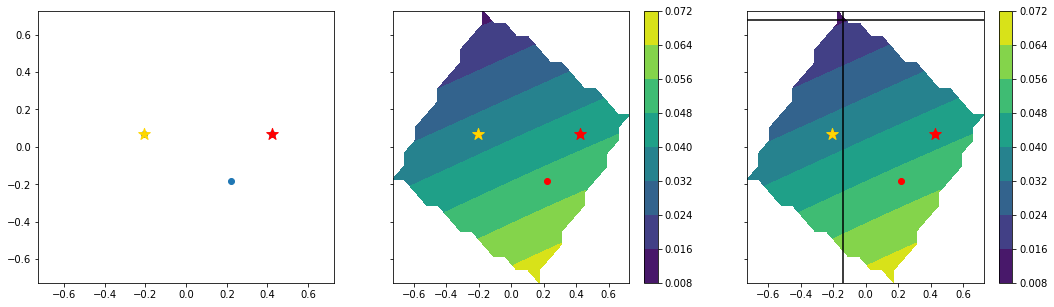

gp(norm) : {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.947368421053


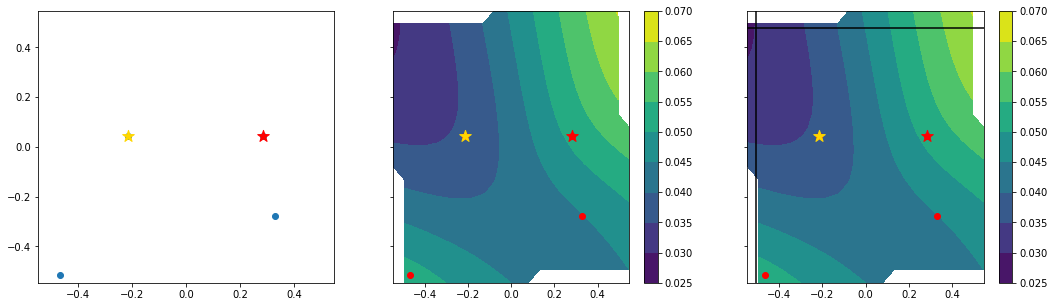

gp(norm) : {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2} 0.947368421053


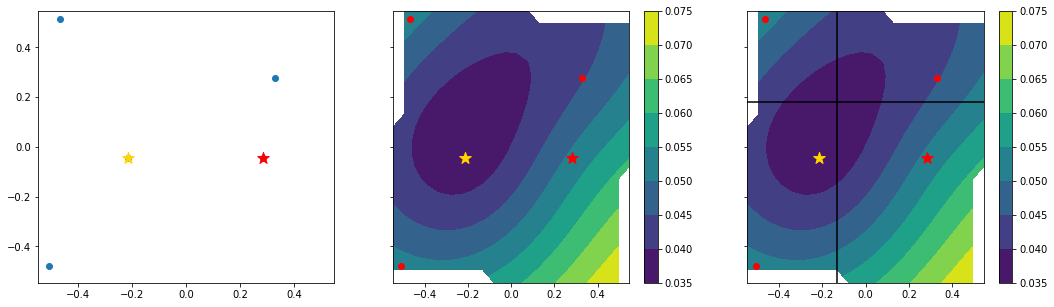

gp(norm) : {'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.956140350877


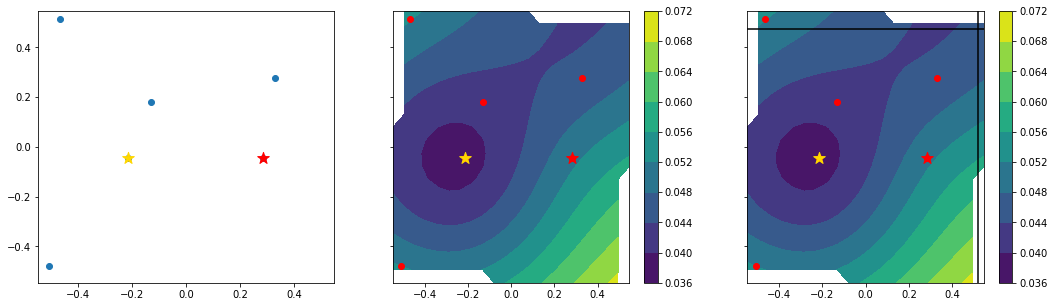

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.956140350877


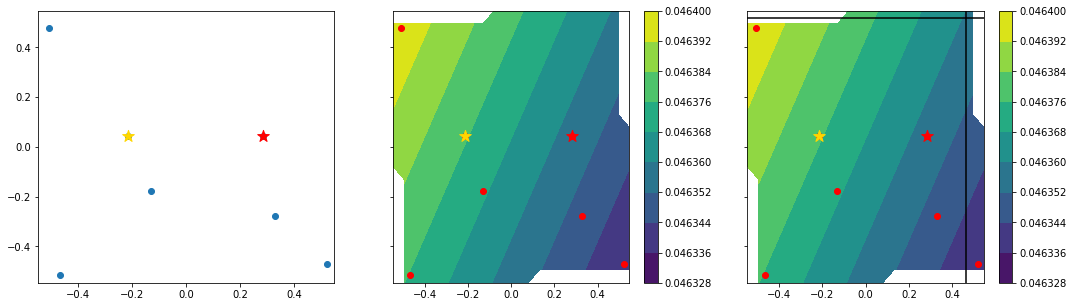

gp(norm) : {'max_features': 'auto', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 2} 0.929824561404


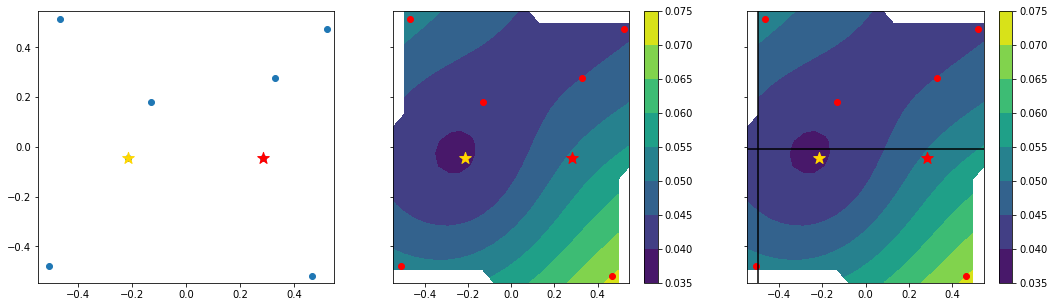

gp(norm) : {'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'max_depth': 3} 0.938596491228


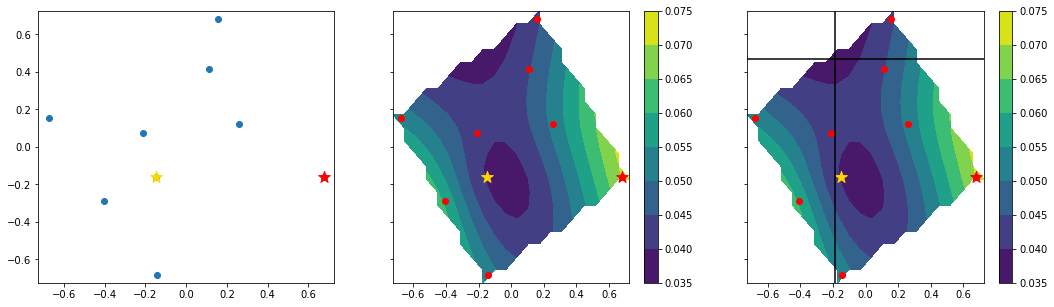

gp(norm) : {'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'max_depth': 4} 0.956140350877


In [48]:
xp, yp = opt.run(sampler_func=sample,
                 n_iters=10)